# Download da base de dados do Supabase

In [126]:
from dotenv import load_dotenv
import pandas as pd
import os
from supabase import create_client



load_dotenv()

SUPABASE_URL = os.environ.get("SUPABASE_URL")
SUPABASE_KEY = os.environ.get("SUPABASE_KEY")
pd.set_option('display.max_columns', None)

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)
query = supabase.table("wine_data").select("*").execute()
db_original = pd.DataFrame(query.data)

In [127]:
db = db_original.copy()

# Informações básica do DataFrame

In [128]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   717 non-null    int64 
 1   product_type                         673 non-null    object
 2   product_name                         717 non-null    object
 3   wine_variety                         673 non-null    object
 4   wine_region                          717 non-null    object
 5   item_quantity                        717 non-null    object
 6   wine_grapes                          303 non-null    object
 7   color_description                    465 non-null    object
 8   scent_description                    464 non-null    object
 9   taste_description                    466 non-null    object
 10  fruit_tasting                        466 non-null    object
 11  sugar_tasting                        466 non-

In [129]:
db.describe()

,id
count,717.000000
mean,360.405858
std,209.145418
min,1.000000
25%,180.000000
50%,359.000000
75%,538.000000
max,725.000000


# Feature Engineering

## Feature: Item quantity -> int 

### Resultado: Foi criada uma feature com o numero de unidade com o tipo int o nome da coluna é: item_quantity_integer

In [130]:
teste = db['item_quantity'].sort_values(ascending=False, key=lambda x: x.str.len())
teste

58     10 unidades
386    10 unidades
179    10 unidades
44     10 unidades
247    10 unidades
          ...     
377              1
376              1
374              1
373              1
716              1
Name: item_quantity, Length: 717, dtype: object

In [131]:
db['item_quantity_integer'] = db['item_quantity'].sort_values(ascending=False, key=lambda x: x.str.len())
db['item_quantity_integer'] = db['item_quantity'].str.split(" ").apply(lambda x: x[0]).astype(int)
db['item_quantity_integer']

0       1
1       1
2      10
3       1
4      10
       ..
712     3
713     1
714     3
715     1
716     1
Name: item_quantity_integer, Length: 717, dtype: int32

In [132]:
db['item_quantity_integer'].max()

12

In [133]:
db.drop("item_quantity", axis='columns', inplace=True)

## Feature: wine_variety -> Retirando os product type nulos. Não são vinhos

### Resultado: As entradas foram retiradas do dataframe que irá pro modelo por possuir uma variedade de itens que não são vinhos

In [134]:
db["wine_variety"].unique()

array(['Vinho tinto', 'Vinho rosé', 'Vinho branco', 'Vários tipos', None,
       'Espumante Branco', 'Espumante Rosé'], dtype=object)

In [135]:
db[db['wine_variety'].isna()].head()

,id,product_type,product_name,wine_variety,wine_region,wine_grapes,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,created_at,specialist_review_content,specialist_review_owner,specialist_review_occupation,photo_url,url,product_name_escaped,item_quantity_integer
10,27,None,Baco | O Jogo dos Vinhos,None,Brasil,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-23T17:59:51.461769,None,None,None,None,https://www.evino.com.br/product/jogo-baco-tab...,None,1
26,236,None,Taca de Acrilico Bordeaux Evino,None,Brasil,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-23T21:14:31.24666,None,None,None,https://res.cloudinary.com/evino/image/upload/...,https://www.evino.com.br/product/taca-de-acril...,None,1
33,661,None,Pesto Genovês De Tommaso Exclusivo Evino - 160g,None,Brasil,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-29T01:32:35.844978,None,None,None,None,None,None,1
37,665,None,BEG Modern & Tropical Brazilian Boutique Infus...,None,Brasil,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-29T01:33:14.302136,None,None,None,None,None,None,1
60,686,None,Negroni Classico Bottled Cocktail - 375 mL,None,Brasil,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-29T01:56:45.831922,None,None,None,None,None,None,1


In [136]:
db = db[db["wine_variety"].isna()==False]

## Feature: product_type 

### Resultado: Os kits são conjuntos de produtos cujas páginas da Evino possuem muito menos informação, o que não é bom para o modelo. Desta forma, foi necessário retirar e criar um dataframe a parte para caso queiramos utilizar mais a frente.

In [137]:
db[db["product_type"]=="Kit"]

,id,product_type,product_name,wine_variety,wine_region,wine_grapes,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,created_at,specialist_review_content,specialist_review_owner,specialist_review_occupation,photo_url,url,product_name_escaped,item_quantity_integer
2,646,Kit,"Kit 10 Malbecs Best Sellers por R$39,90 cada g...",Vinho tinto,Argentina,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-27T02:24:47.940844,None,None,None,None,None,None,10
4,648,Kit,"Kit 10 Vinhos Brancos por R$24,90 cada garrafa*",Vinho branco,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-27T02:25:20.456657,None,None,None,None,None,None,10
5,11,Kit,Kit Primitivos Best Sellers | 6 garrafas por R...,Vinho tinto,Itália,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T02:37:57.406997,None,None,None,None,https://www.evino.com.br/product/6-primitivos-...,None,6
6,1,Kit,Kit 3 Malbecs Best Sellers + Bolsa Térmica,Vários tipos,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T03:18:12.856299,None,None,None,None,https://www.evino.com.br/product/kit-3-malbecs...,None,4
7,638,Kit,Kit Lançamentos Italianos,Vários tipos,Itália,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-27T14:42:02.199078,None,None,None,None,None,None,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,344,Kit,Kit Vinhos Mais Vendidos de 2024,Vários tipos,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-23T22:59:07.27482,None,None,None,https://res.cloudinary.com/evino/image/upload/...,https://www.evino.com.br/product/kit-os-melhor...,None,4
635,447,Kit,Kit Linha Atardecer de Los Andes + Kit 6 Marca...,Vários tipos,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T00:55:01.854817,None,None,None,None,https://www.evino.com.br/product/kit-linha-ata...,None,5
689,25,Kit,"Kit 3 Espumantes Best Sellers por R$109,90 cad...",Vários tipos,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T02:38:13.208747,None,None,None,None,https://www.evino.com.br/product/kit-3-espuman...,None,3
696,102,Kit,Kit Primitivos di Manduria | 2 Casale Brondell...,Vinho tinto,Itália,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T02:41:25.57598,None,None,None,None,https://www.evino.com.br/product/kit-4-primiti...,None,4


In [138]:
db_kits = db[db['product_type']=="Kit"]
db = db[db['product_type']!="Kit"]

In [139]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 476 entries, 0 to 716
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   476 non-null    int64 
 1   product_type                         476 non-null    object
 2   product_name                         476 non-null    object
 3   wine_variety                         476 non-null    object
 4   wine_region                          476 non-null    object
 5   wine_grapes                          303 non-null    object
 6   color_description                    465 non-null    object
 7   scent_description                    464 non-null    object
 8   taste_description                    466 non-null    object
 9   fruit_tasting                        466 non-null    object
 10  sugar_tasting                        466 non-null    object
 11  acidity_tasting                      466 non-null 

## Feature wine_grapes -> Avaliação

### Resultado: Talvez seja improtante retirar essas entradas do dataframe principal, assim como fiz com os kits e separá-las num outro df que juntarei com o df dos kits. 

In [140]:
db["wine_grapes"].unique()

array(['Blend, Cinsault, Grenache, Syrah', 'Uvas variadas', 'Barbera',
       None, 'Cabernet Sauvignon', 'Blend', 'Siria, Fonte da Cal',
       'Primitivo', 'Tempranillo', 'Touriga Nacional',
       'Sangiovese, Merlot', 'Sauvignon Blanc', 'Negroamaro, Malvasia',
       'Carménère', 'Cabernet Sauvignon, Ciliegiolo, Sangiovese',
       'Aglianico, Negroamaro, Primitivo', 'Criolla',
       'Blend, Negroamaro, Uvas variadas', 'Bonarda', 'Malbec',
       'Cabernet Sauvignon, Merlot, Uvas variadas',
       'Jaén, Touriga Nacional, Aragonez', 'Tempranillo, Merlot, Syrah',
       'Montepulciano', 'Merlot', 'Torrontés', 'Pinot Grigio',
       'Arinto, Trajadura', 'Chardonnay', 'Garnacha, Syrah, Tempranillo',
       'Pinot Noir', 'Bobal', 'Blend, Tempranillo',
       'Garnacha, Tempranillo', 'Nebbiolo', 'Garnacha',
       'Grenache, Syrah, Tempranillo',
       'Blend, Chardonnay, Chenin Blanc, Torrontés', 'Syrah', 'Airén',
       'Barbera, Dolcetto, Freisa, Bonarda, Albarossa, Merlot, Syrah, C

In [141]:
db[db["wine_grapes"].isna()]

,id,product_type,product_name,wine_variety,wine_region,wine_grapes,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,created_at,specialist_review_content,specialist_review_owner,specialist_review_occupation,photo_url,url,product_name_escaped,item_quantity_integer
8,641,Vinho tinto francês,Kit Leve 6 Pague 3 Cave de Ladac Grand d'Excel...,Vinho tinto,França,None,None,None,None,None,None,None,None,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,None,None,França,Bordeaux,13%,"Merlot, Cabernet Sauvignon",E.L.G,2022,None,None,2025-03-27T14:42:28.623472,None,None,None,None,None,None,6
13,649,Espumante Branco espanhol,"Kit 9 Tanggier Brut por R$33,32 cada garrafa",Espumante Branco,Espanha,None,Amarelo-palha,"Notas de pêra, pêssego e minerais","Corpo leve, delicado, com muita fruta",4,2,3,1,"Saladas e aperitivos, Carnes brancas, Frutos d...",Espumante Branco,750ml,Rolha,9ºC,Espanha,Multirregional,10%,Uvas variadas,None,None,2025,None,2025-03-27T15:06:44.16999,None,Ari Gorenstein,Sommelier da evino,None,None,None,9
22,653,Vinho tinto italiano,Kit 2 Cuvée 16 Limited Edition Vino Rosso d'It...,Vinho tinto,Itália,None,Vermelho-rubi profundo com reflexos violáceos,"Intenso e complexo, com notas de compotas de f...","Aveludado, redondo, frutado, taninos macios e ...",4,1,2,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha de cortiça,17ºC,Itália,Multirregional,16%,Uvas variadas,None,None,None,None,2025-03-29T00:39:14.983701,None,Vinícius Santiago,Sommelier da evino,None,None,None,2
24,654,Vinho tinto português,Kit 3 Solouro Tinto,Vinho tinto,Portugal,None,Vermelho-granada intenso,Notas intensas de frutas vermelhas e pretas ma...,"Encorpado, redondo e frutado, com taninos marc...",3,1,3,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha de cortiça,15ºC,Portugal,None,12%,"Touriga Franca, Tinta Roriz",None,None,2025,None,2025-03-29T00:43:28.54111,None,Ari Gorenstein,Sommelier da evino,None,None,None,3
27,657,Espumante Branco espanhol,Kit 6 Tanggier Brut*,Espumante Branco,Espanha,None,Amarelo-palha,"Notas de pêra, pêssego e minerais","Corpo leve, delicado, com muita fruta",4,2,3,1,"Saladas e aperitivos, Carnes brancas, Frutos d...",Espumante Branco,750ml,Rolha,9ºC,Espanha,Multirregional,10%,Uvas variadas,None,None,2025,None,2025-03-29T00:49:00.719741,None,Ari Gorenstein,Sommelier da evino,None,None,None,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,285,Vinho tinto italiano,Kit 4 Infinitum Montepulciano d'Abruzzo DOC po...,Vinho tinto,Itália,None,Vermelho-rubi,Notas de cerejas maduras e amoras,"Equilibrado e encorpado, com taninos macios",3,1,3,2,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha,16ºC,Itália,Abruzzo,12.5%,Montepulciano,Deangeli Musti Nobilis,None,2025,None,2025-03-24T03:20:25.177931,None,Vinícius Santiago,Sommelier da evino,None,https://www.evino.com.br/product/kit-4-vini-de...,None,4
710,306,Vinho tinto italiano,Kit 3 Conte Parelli Appassimento Puglia IGT po...,Vinho tinto,Itália,None,Vermelho-rubi intenso com reflexos violáceos,"Notas intensas de frutas vermelhas maduras, e ...","Elegante e harmonioso, com taninos aveludados ...",4,2,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,17ºC,Itália,Puglia,15%,"Blend, Negroamaro, Uvas variadas",Angelo Rocca e Figli Srl,2021,2025,Estágio em barricas de carvalho francês,2025-03-24T03:21:06.626014,None,Vinícius Santiago,Sommelier da evino,None,ht

In [142]:
db["product_name_with_word_kit"] = db['product_name'].str.contains("Kit", case=False)

In [143]:
db[db["product_name_with_word_kit"]==True].info()

<class 'pandas.core.frame.DataFrame'>
Index: 173 entries, 8 to 714
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   173 non-null    int64 
 1   product_type                         173 non-null    object
 2   product_name                         173 non-null    object
 3   wine_variety                         173 non-null    object
 4   wine_region                          173 non-null    object
 5   wine_grapes                          0 non-null      object
 6   color_description                    170 non-null    object
 7   scent_description                    169 non-null    object
 8   taste_description                    170 non-null    object
 9   fruit_tasting                        170 non-null    object
 10  sugar_tasting                        170 non-null    object
 11  acidity_tasting                      170 non-null 

In [144]:
pd.set_option('display.max_columns', None)
db[db["product_name_with_word_kit"]==True]

,id,product_type,product_name,wine_variety,wine_region,wine_grapes,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,created_at,specialist_review_content,specialist_review_owner,specialist_review_occupation,photo_url,url,product_name_escaped,item_quantity_integer,product_name_with_word_kit
8,641,Vinho tinto francês,Kit Leve 6 Pague 3 Cave de Ladac Grand d'Excel...,Vinho tinto,França,None,None,None,None,None,None,None,None,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,None,None,França,Bordeaux,13%,"Merlot, Cabernet Sauvignon",E.L.G,2022,None,None,2025-03-27T14:42:28.623472,None,None,None,None,None,None,6,True
13,649,Espumante Branco espanhol,"Kit 9 Tanggier Brut por R$33,32 cada garrafa",Espumante Branco,Espanha,None,Amarelo-palha,"Notas de pêra, pêssego e minerais","Corpo leve, delicado, com muita fruta",4,2,3,1,"Saladas e aperitivos, Carnes brancas, Frutos d...",Espumante Branco,750ml,Rolha,9ºC,Espanha,Multirregional,10%,Uvas variadas,None,None,2025,None,2025-03-27T15:06:44.16999,None,Ari Gorenstein,Sommelier da evino,None,None,None,9,True
22,653,Vinho tinto italiano,Kit 2 Cuvée 16 Limited Edition Vino Rosso d'It...,Vinho tinto,Itália,None,Vermelho-rubi profundo com reflexos violáceos,"Intenso e complexo, com notas de compotas de f...","Aveludado, redondo, frutado, taninos macios e ...",4,1,2,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha de cortiça,17ºC,Itália,Multirregional,16%,Uvas variadas,None,None,None,None,2025-03-29T00:39:14.983701,None,Vinícius Santiago,Sommelier da evino,None,None,None,2,True
24,654,Vinho tinto português,Kit 3 Solouro Tinto,Vinho tinto,Portugal,None,Vermelho-granada intenso,Notas intensas de frutas vermelhas e pretas ma...,"Encorpado, redondo e frutado, com taninos marc...",3,1,3,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha de cortiça,15ºC,Portugal,None,12%,"Touriga Franca, Tinta Roriz",None,None,2025,None,2025-03-29T00:43:28.54111,None,Ari Gorenstein,Sommelier da evino,None,None,None,3,True
27,657,Espumante Branco espanhol,Kit 6 Tanggier Brut*,Espumante Branco,Espanha,None,Amarelo-palha,"Notas de pêra, pêssego e minerais","Corpo leve, delicado, com muita fruta",4,2,3,1,"Saladas e aperitivos, Carnes brancas, Frutos d...",Espumante Branco,750ml,Rolha,9ºC,Espanha,Multirregional,10%,Uvas variadas,None,None,2025,None,2025-03-29T00:49:00.719741,None,Ari Gorenstein,Sommelier da evino,None,None,None,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,285,Vinho tinto italiano,Kit 4 Infinitum Montepulciano d'Abruzzo DOC po...,Vinho tinto,Itália,None,Vermelho-rubi,Notas de cerejas maduras e amoras,"Equilibrado e encorpado, com taninos macios",3,1,3,2,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha,16ºC,Itália,Abruzzo,12.5%,Montepulciano,Deangeli Musti Nobilis,None,2025,None,2025-03-24T03:20:25.177931,None,Vinícius Santiago,Sommelier da evino,None,https://www.evino.com.br/product/kit-4-vini-de...,None,4,True
710,306,Vinho tinto italiano,Kit 3 Conte Parelli Appassimento Puglia IGT po...,Vinho tinto,Itália,None,Vermelho-rubi intenso com reflexos violáceos,"Notas intensas de frutas vermelhas maduras, e ...","Elegante e harmonioso, com taninos aveludados ...",4,2,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,17ºC,Itália,Puglia,15%,"Blend, Negroamaro, Uvas variadas",Angelo Rocca e Figli Srl,2021,2025,Estágio em barricas de carvalho francês,2025-03-24T03:2

In [145]:
db[db["product_name"].str.contains("African Horizon Pinotage Western")]

,id,product_type,product_name,wine_variety,wine_region,wine_grapes,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,created_at,specialist_review_content,specialist_review_owner,specialist_review_occupation,photo_url,url,product_name_escaped,item_quantity_integer,product_name_with_word_kit
159,40,Vinho tinto sul-africano,Kit 3 The African Horizon Pinotage Western Cap...,Vinho tinto,África do Sul,None,Vermelho-rubi,"Notas de frutas vermelhas, como cereja e grose...","Frutado e suculento, ressaltando taninos macio...",3,1,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Tampa de rosca,15ºC,África do Sul,Western Cape,13%,Pinotage,Origin Wine,2023,2025,None,2025-03-23T18:03:31.029735,None,Vinícius Santiago,Sommelier da evino,https://res.cloudinary.com/evino/image/upload/...,https://www.evino.com.br/product/kit-3-origin-...,None,3,True
667,543,Vinho tinto sul-africano,The African Horizon Pinotage Western Cape W.O....,Vinho tinto,África do Sul•,Pinotage,Vermelho-rubi,"Notas de frutas vermelhas, como cereja e grose...","Frutado e suculento, ressaltando taninos macio...",3,1,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Tampa de rosca,15ºC,África do Sul,Western Cape,13%,Pinotage,Origin Wine,2023,2025,None,2025-03-24T01:58:16.95541,"Uva tinta mais famosa da África do Sul, a Pino...",Vinícius Santiago,Sommelier da evino,None,https://www.evino.com.br/product/origin-wine-t...,None,1,False


Observação: 
Como as entradas são identicas mas com menos volume de informações, por exemplo: em kits de produtos tem as avaliações de força de acidez, nível de fruta e etc mas não tem a avaliação do especialista. Talvez seja improtante retirar essas entradas do dataframe principal, assim como fiz com os kits e separá-las num outro df que juntarei com o df dos kits.

In [146]:
db_kits_from_product_name = db[db['product_name_with_word_kit']==True]
db = db[db['product_name_with_word_kit']==False]


db_all_kits = pd.concat([db_kits, db_kits_from_product_name], axis=0,ignore_index=True)

In [147]:
db_all_kits

,id,product_type,product_name,wine_variety,wine_region,wine_grapes,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,created_at,specialist_review_content,specialist_review_owner,specialist_review_occupation,photo_url,url,product_name_escaped,item_quantity_integer,product_name_with_word_kit
0,646,Kit,"Kit 10 Malbecs Best Sellers por R$39,90 cada g...",Vinho tinto,Argentina,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-27T02:24:47.940844,None,None,None,None,None,None,10,NaN
1,648,Kit,"Kit 10 Vinhos Brancos por R$24,90 cada garrafa*",Vinho branco,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-27T02:25:20.456657,None,None,None,None,None,None,10,NaN
2,11,Kit,Kit Primitivos Best Sellers | 6 garrafas por R...,Vinho tinto,Itália,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T02:37:57.406997,None,None,None,None,https://www.evino.com.br/product/6-primitivos-...,None,6,NaN
3,1,Kit,Kit 3 Malbecs Best Sellers + Bolsa Térmica,Vários tipos,Vários países,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-24T03:18:12.856299,None,None,None,None,https://www.evino.com.br/product/kit-3-malbecs...,None,4,NaN
4,638,Kit,Kit Lançamentos Italianos,Vários tipos,Itália,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,2025-03-27T14:42:02.199078,None,None,None,None,None,None,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,285,Vinho tinto italiano,Kit 4 Infinitum Montepulciano d'Abruzzo DOC po...,Vinho tinto,Itália,None,Vermelho-rubi,Notas de cerejas maduras e amoras,"Equilibrado e encorpado, com taninos macios",3,1,3,2,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha,16ºC,Itália,Abruzzo,12.5%,Montepulciano,Deangeli Musti Nobilis,None,2025,None,2025-03-24T03:20:25.177931,None,Vinícius Santiago,Sommelier da evino,None,https://www.evino.com.br/product/kit-4-vini-de...,None,4,True
366,306,Vinho tinto italiano,Kit 3 Conte Parelli Appassimento Puglia IGT po...,Vinho tinto,Itália,None,Vermelho-rubi intenso com reflexos violáceos,"Notas intensas de frutas vermelhas maduras, e ...","Elegante e harmonioso, com taninos aveludados ...",4,2,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,17ºC,Itália,Puglia,15%,"Blend, Negroamaro, Uvas variadas",Angelo Rocca e Figli Srl,2021,2025,Estágio em barricas de carvalho francês,2025-03-24T03:21:06.626014,None,Vinícius Santiago,Sommelier da evino,None,https://www.evino.com.br/product/kit-3-conte-p...,None,3,True
367,354,Espumante Branco francês,Kit 4 Première Bulle Blanquette de Limoux AOC ...,Espumante Branco,França,None,Dourado pálido com perlages finos,Aromas delicados de frutas cítricas e flores b...,"Vivaz e redondo, com textura agradável, notas ...",3,1,4,1,"Carnes brancas, Frutos do mar, Risoto e massas...",Espumante Branco,750ml,Rolha de cortiça,6ºC,França,Languedoc-Roussillon,12.5%,"Mauzac, Chardonnay, Chenin Blanc",Sieur d'Arques,None,2025,Envelhecimento sobre as borras por 18 meses,2025-03-24T03:22:08.758223,None,Vinícius Santiago,Sommelier da evino,None,https://www.evino.com.br/product/kit-4-premier...,None,4,True
368,383,Vinho branco sul-africano,Kit 3 The African Horizon Chenin Blanc Western...,Vinho branco,África 

## Features: wine_grapes e technical_sheet_grapes

### Resultado: Podemos desconsiderar uma das duas colunas dado que os valores são todos iguais.

In [148]:
db[['wine_grapes', "technical_sheet_grapes"]]

,wine_grapes,technical_sheet_grapes
0,"Blend, Cinsault, Grenache, Syrah","Blend, Cinsault, Grenache, Syrah"
1,Uvas variadas,Uvas variadas
3,Barbera,Barbera
11,Cabernet Sauvignon,Cabernet Sauvignon
21,Blend,Blend
...,...,...
707,Malbec,Malbec
708,Grenache,Grenache
713,Nebbiolo,Nebbiolo
715,Blend,Blend


In [149]:
db['wine_grapes_equal_tech_sheet'] = db['wine_grapes']==db['technical_sheet_grapes']
db['wine_grapes_equal_tech_sheet'].value_counts()

wine_grapes_equal_tech_sheet
True    303
Name: count, dtype: int64

In [150]:
db.drop("wine_grapes", axis='columns', inplace=True)

Podemos desconsiderar uma das duas colunas dado que os valores são todos iguais.

## Features: wine_variety e technical_sheet_wine_type

### Resultado: A variável product_type é uma informação mais detalhada das outras duas variáveis

In [151]:
db[["product_type", "wine_variety", "technical_sheet_wine_type"]]

,product_type,wine_variety,technical_sheet_wine_type
0,Vinho tinto francês,Vinho tinto,Vinho tinto
1,Vinho rosé português,Vinho rosé,Vinho rosé
3,Vinho tinto italiano,Vinho tinto,Vinho tinto
11,Vinho tinto argentino,Vinho tinto,Vinho tinto
21,Vinho rosé chileno,Vinho rosé,Vinho rosé
...,...,...,...
707,Vinho tinto argentino,Vinho tinto,Vinho tinto
708,Espumante Rosé brasileiro,Espumante Rosé,Espumante Rosé
713,Vinho tinto italiano,Vinho tinto,Vinho tinto
715,Vinho tinto chileno,Vinho tinto,Vinho tinto


In [152]:
db["product_type"].unique()

array(['Vinho tinto francês', 'Vinho rosé português',
       'Vinho tinto italiano', 'Vinho tinto argentino',
       'Vinho rosé chileno', 'Vinho branco português',
       'Vinho rosé espanhol', 'Vinho tinto chileno',
       'Vinho branco argentino', 'Vinho tinto português',
       'Vinho branco chileno', 'Espumante Branco francês',
       'Espumante Branco brasileiro', 'Vinho rosé argentino',
       'Vinho tinto espanhol', 'Vinho branco sul-africano',
       'Vinho tinto europeu', 'Vinho rosé europeu',
       'Espumante Branco espanhol', 'Vinho branco italiano',
       'Vinho branco espanhol', 'Vinho rosé sul-africano',
       'Vinho rosé italiano', 'Espumante Rosé francês',
       'Vinho branco francês', 'Espumante Rosé espanhol',
       'Espumante Branco argentino', 'Espumante Rosé brasileiro',
       'Vinho rosé francês', 'Vinho tinto sul-africano',
       'Vinho branco brasileiro'], dtype=object)

A variável product_type é uma informação mais detalhada das outras duas variáveis

In [153]:
db['wine_variety_equal_tech_sheet'] = db['wine_variety']==db['technical_sheet_wine_type']
db['wine_grapes_equal_tech_sheet'].value_counts()

wine_grapes_equal_tech_sheet
True    303
Name: count, dtype: int64

In [154]:
db.drop("wine_variety", axis='columns', inplace=True)

Também podemos desconsiderar uma das duas variáveis dado que elas são iguais.

## Features: wine_region e technical_sheet_country

### Resultado: Podemos desconsiderar uma das duas variáveis 'wine_region' ou'technical_sheet_country' dado que são iguais.

In [155]:
db[['wine_region', 'technical_sheet_region', 'technical_sheet_country']].head(5)

,wine_region,technical_sheet_region,technical_sheet_country
0,França•,Vale do Rhône,França
1,Portugal•,Multirregional,Portugal
3,Itália•,Piemonte,Itália
11,Argentina•,Mendoza,Argentina
21,Chile•,Valle del Maule,Chile


In [156]:
db['wine_region'] = db['wine_region'].str.replace("•", "")

In [157]:
db[['wine_region','technical_sheet_country']].value_counts()

wine_region    technical_sheet_country
Argentina      Argentina                  72
Chile          Chile                      70
Espanha        Espanha                    48
Itália         Itália                     42
Portugal       Portugal                   23
França         França                     18
Europeu        Europeu                    14
Brasil         Brasil                     11
África do Sul  África do Sul               5
Name: count, dtype: int64

In [158]:
db['wine_region_equal_tech_sheet'] = db['wine_region']==db['technical_sheet_country']
db['wine_region_equal_tech_sheet'].value_counts()

wine_region_equal_tech_sheet
True    303
Name: count, dtype: int64

In [159]:
db[['wine_region','technical_sheet_country']].head(5)

,wine_region,technical_sheet_country
0,França,França
1,Portugal,Portugal
3,Itália,Itália
11,Argentina,Argentina
21,Chile,Chile


In [160]:
db.drop("wine_region", axis='columns', inplace=True)

Podemos desconsiderar uma das duas variáveis 'wine_region' ou'technical_sheet_country' dado que são iguais.

## Features: fruit_tasting, tannin_tasting, sugar_tasting e acidity_tasting


### Resultado: Como todos os itens que não possuem avaliação são os mesmos, a melhor alternativa é tirá-los para não serem um problema no modelo de machine learning.

In [161]:
db.loc[db['fruit_tasting'].isna()==True]['id'].tolist()

[559, 238, 261, 499, 460, 557, 42]

In [162]:
db.loc[db['tannin_tasting'].isna()==True]['id'].tolist()

[559, 238, 261, 499, 460, 557, 42]

In [163]:
db.loc[db['sugar_tasting'].isna()==True]['id'].tolist()

[559, 238, 261, 499, 460, 557, 42]

In [164]:
db.loc[db['acidity_tasting'].isna()==True]['id'].tolist()

[559, 238, 261, 499, 460, 557, 42]

Como todos os itens que não possuem avaliação são os mesmos, a melhor alternativa é tirá-los para não serem um problema no modelo de machine learning.

In [165]:
db = db.loc[db['acidity_tasting'].isna()==False]

In [166]:
db['id'].count()

296

## Feature: product_name

### Resultado: Após as exclusões anteriores, agora esta feature não possui mais nomes "sujos", portanto não será necessário realizar nenhum tipo de limpeza aqui.

In [167]:
db['product_name'].unique()

array(['La Chaise des Papes Châteauneuf-du-Pape AOC 2022',
       'Travessia Rosé',
       'Stardust Edição Limitada Taurus Rosso Piemonte DOC 2020',
       'La Grupa Cabernet Sauvignon Gran Selección 2023',
       'San Nazareno Winemaker Selection Rosé 2024', 'Travessia Branco',
       'San Cristaldo in Fonteroma Primitivo Di Puglia 2021',
       'Castillo De Soldepeñas Rosado Tempranillo',
       'El Origen Winemaker Selection del Limarí Cabernet Sauvignon 2024',
       'Las Colinas de Los Andes White Blend 2024',
       "Grand'Arte Touriga Nacional Vinho Regional Lisboa 2019",
       'Stardust Edição Limitada Sagittarius Rosso Toscana IGT 2020',
       'Playa Azul Winemaker Selection Sauvignon Blanc Central Valley D.O. 2023',
       'Aves Del Sur Cabernet Sauvignon Valle del Loncomilla D.O. 2023',
       'Lupo Meraviglia Due di Due Rosso di Puglia IGT 2022',
       'Champagne Veuve Clicquot Brut',
       'Lagunas Rosé Valle Central D.O. 2024',
       'Champagne Armand de Brignac “Ac

Observação: Essa feature contém os nomes corretos, uma vez que tiramos os kits e demais sujeiras do dataset. Não é necessário fazer nada aqui.

## Feature: technical_sheet_service_temperature -> technical_sheet_service_temperature_in_celsius

In [168]:
db["technical_sheet_service_temperature"] = db["technical_sheet_service_temperature"].str.replace("ºC", "")
db.rename(columns={'technical_sheet_service_temperature': 'technical_sheet_service_temperature_in_celsius'}, inplace=True)
db['technical_sheet_service_temperature_in_celsius']

0      16
1      10
3      18
11     18
21      8
       ..
707    18
708     9
713    17
715    16
716    18
Name: technical_sheet_service_temperature_in_celsius, Length: 296, dtype: object

## Feature: technical_sheet_alcohol_content

In [169]:
db["technical_sheet_alcohol_content"] = db["technical_sheet_alcohol_content"].str.replace("%","")
db["technical_sheet_alcohol_content"]

0        15
1      11.5
3      13.5
11       13
21     12.5
       ... 
707    12.5
708      12
713      14
715    12.5
716    13.5
Name: technical_sheet_alcohol_content, Length: 296, dtype: object

## Features: fruit_tasting,sugar_tasting, acidity_tasting, tannin_tasting

In [170]:
db[['fruit_tasting','sugar_tasting', 
    'acidity_tasting', 'tannin_tasting']] = db[['fruit_tasting','sugar_tasting', 
                                                'acidity_tasting', 'tannin_tasting']].astype(int)

# EDA

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

eda_df = db.copy()

In [172]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 716
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   id                                              296 non-null    int64 
 1   product_type                                    296 non-null    object
 2   product_name                                    296 non-null    object
 3   color_description                               295 non-null    object
 4   scent_description                               295 non-null    object
 5   taste_description                               296 non-null    object
 6   fruit_tasting                                   296 non-null    int32 
 7   sugar_tasting                                   296 non-null    int32 
 8   acidity_tasting                                 296 non-null    int32 
 9   tannin_tasting                                  296 non-nul

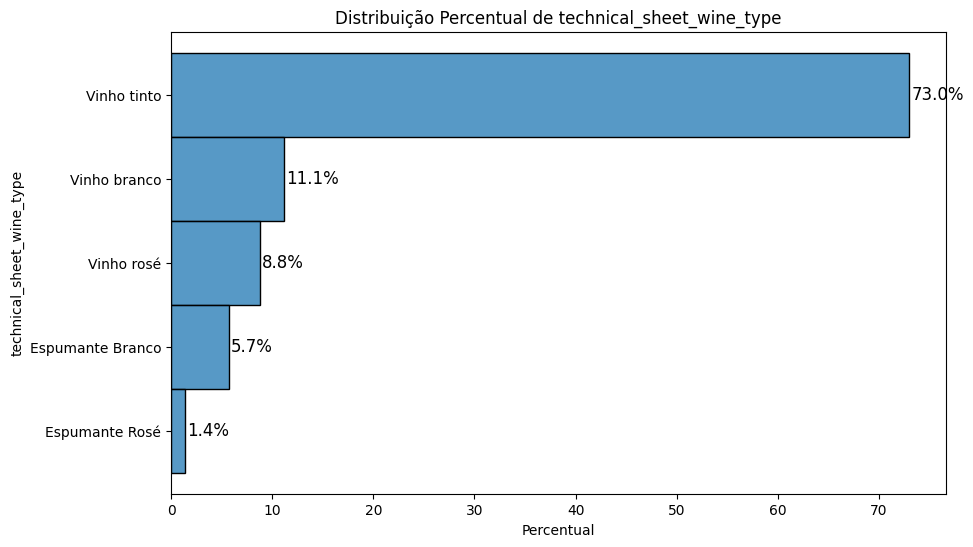

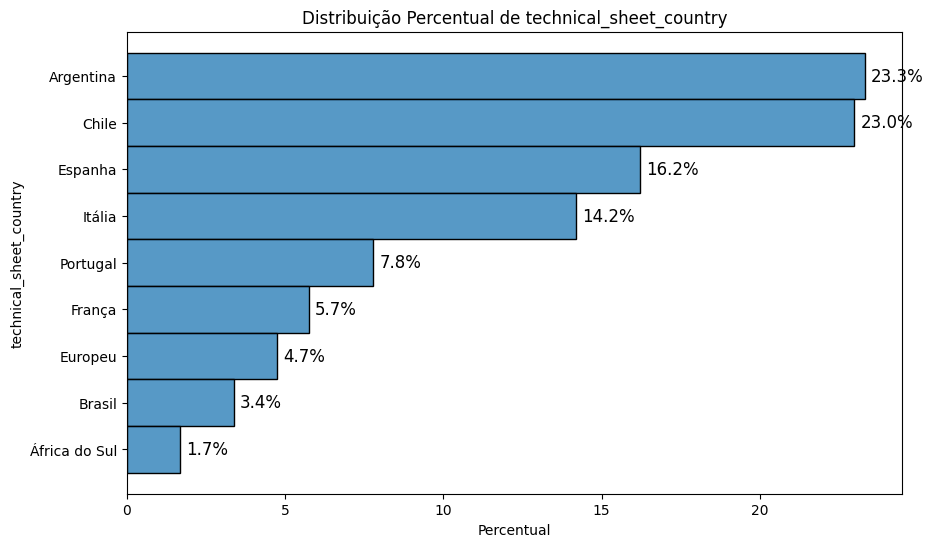

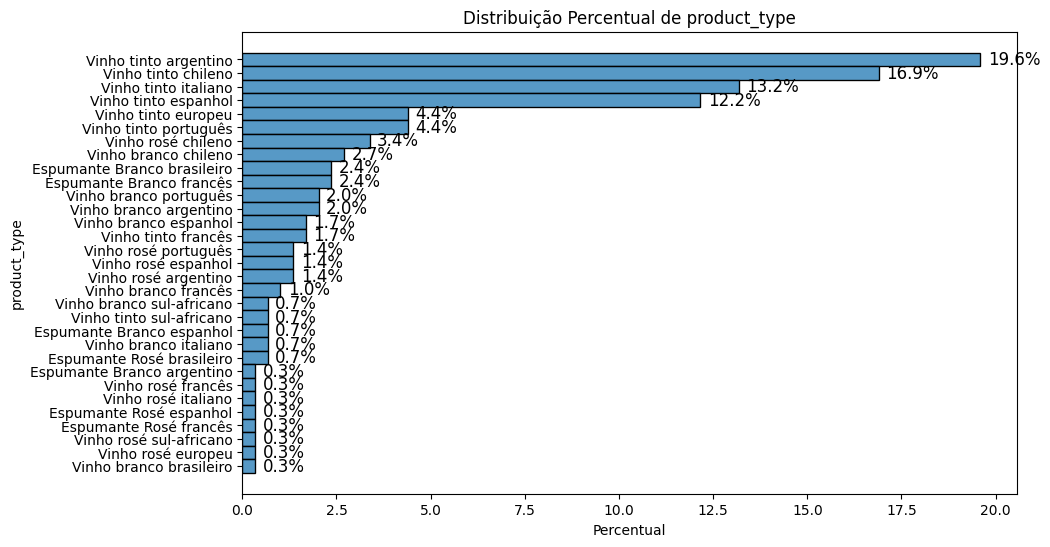

In [173]:
columns = ['technical_sheet_wine_type', 'technical_sheet_country', 'product_type']

for col in columns:
    # Conta a frequência dos valores únicos e ordena do maior para o menor
    sorted_counts = eda_df[col].value_counts().sort_values(ascending=False)
    total = sorted_counts.sum()  # Total de ocorrências para calcular percentual
    
    # Criar um DataFrame temporário ordenado para o plot
    sorted_df = eda_df[eda_df[col].isin(sorted_counts.index)].copy()
    sorted_df[col] = sorted_df[col].astype("category")
    sorted_df[col] = sorted_df[col].cat.set_categories(sorted_counts.index, ordered=True)

    # Criar o histograma com percentuais
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = sns.histplot(data=sorted_df, y=col, kde=False, discrete=True, 
                        cumulative=False, multiple='stack', stat='percent', ax=ax)

    # Adicionar os valores ao lado das barras
    for bar, count in zip(bars.patches, sorted_counts.values):
        percent = (count / total) * 100  # Calcula o percentual
        ax.text(bar.get_width()+0.2,  # Posição X (fora da barra)
                bar.get_y() + bar.get_height() / 2,  # Posição Y (meio da barra)
                f"{percent:.1f}%",  # Exibe percentual com 1 casa decimal
                va='center', ha='left', fontsize=12, color='black')

    # Configurações do gráfico
    plt.title(f"Distribuição Percentual de {col}")
    plt.xlabel("Percentual")
    plt.ylabel(col)
    plt.show()

É possível perceber que temos dados não balanceados para algumas das nossas features estão bem desbalanceadas:

* Vinho tinto domina os vinhos disponíveis no site da Evino, com 73% dos vinhos coletados. 
* Argentina e Chile são países dominantes na produção de vinhos e isso é refletido também na amostra de vinhos que coletamos do site
* A diferença entre as nacionalidades é refletida também nos dados quando descemos um nível de segmentação dos vinhos por nacionalidade e por tipo.

Certamente devemos ter cuidado com a base devido a essas características de desbalanceamento.


Agora vamos analisar os índices de avaliação sensoriais:

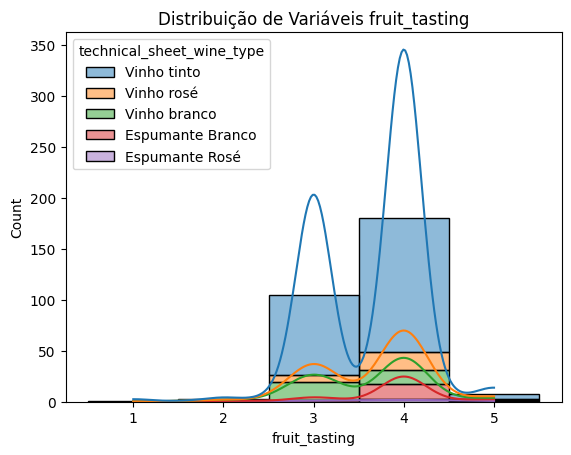

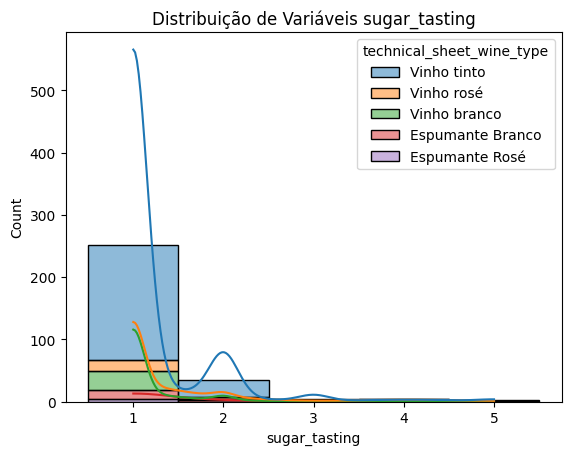

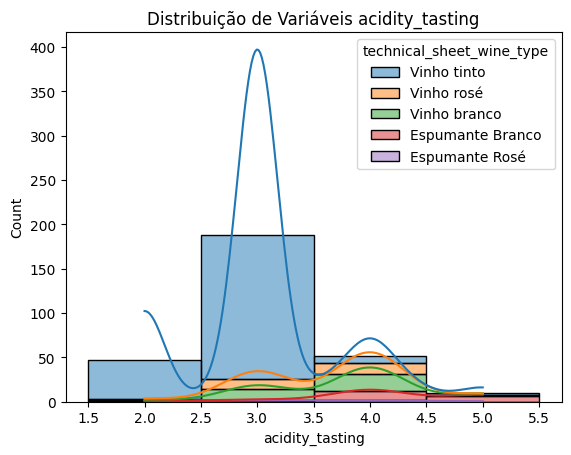

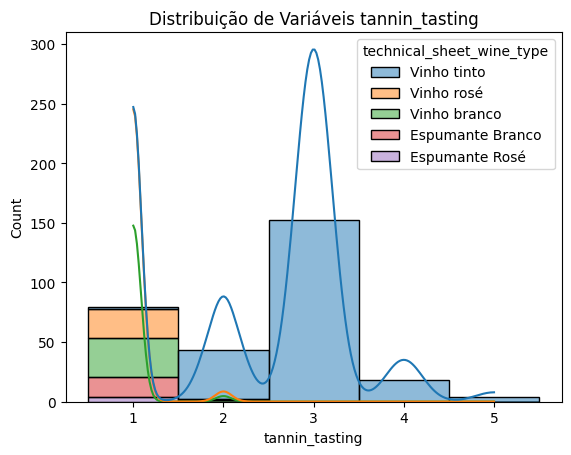

In [174]:
columns = ['fruit_tasting', 'sugar_tasting', 'acidity_tasting', 'tannin_tasting',]

for col in columns:
    
    sns.histplot(data=eda_df , x=col, kde=True, 
                 discrete=True, cumulative=False, stat='count',
                 multiple='stack', hue='technical_sheet_wine_type')\
                .set_title(f"Distribuição de Variáveis {col}")
    plt.show()

In [175]:
import itertools

C:\Users\victo\AppData\Local\Temp\ipykernel_3980\224312979.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=real_counts.head(20), y="combination", x="count", palette="viridis")


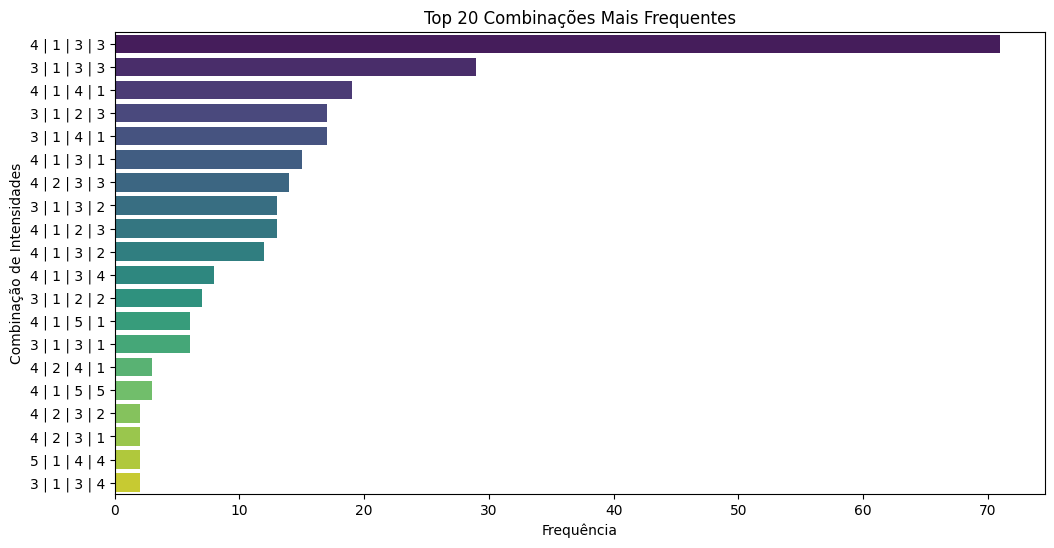

In [176]:
columns = ['fruit_tasting', 'sugar_tasting', 'acidity_tasting', 'tannin_tasting',]

# Contar as combinações reais no dataset
real_counts = eda_df[columns].value_counts().reset_index()
real_counts.columns = columns + ["count"]

# Criar uma coluna com a combinação em formato string para visualização
real_counts["combination"] = real_counts[columns].astype(str).agg(" | ".join, axis=1)

# Ordenar pelas combinações mais frequentes
real_counts = real_counts.sort_values(by="count", ascending=False)

# Plotar as combinações mais frequentes
plt.figure(figsize=(12, 6))
sns.barplot(data=real_counts.head(20), y="combination", x="count", palette="viridis")

plt.xlabel("Frequência")
plt.ylabel("Combinação de Intensidades")
plt.title("Top 20 Combinações Mais Frequentes")
plt.show()

In [177]:
db.drop(["created_at", "photo_url", "product_name_with_word_kit", 
         "wine_grapes_equal_tech_sheet", "wine_variety_equal_tech_sheet", 
         "wine_region_equal_tech_sheet", "item_quantity_integer"], axis='columns', inplace=True)

In [178]:
db.head(10)

,id,product_type,product_name,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature_in_celsius,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,specialist_review_content,specialist_review_owner,specialist_review_occupation,url,product_name_escaped
0,644,Vinho tinto francês,La Chaise des Papes Châteauneuf-du-Pape AOC 2022,Vermelho-rubi intenso,"Aromas intensos de frutas pretas e vermelhas, ...","Concentrado, com acidez refrescante",3,1,4,2,None,Vinho tinto,750ml,Rolha natural,16,França,Vale do Rhône,15,"Blend, Cinsault, Grenache, Syrah",Domaine Albin Jacumin,2022,2027,12 meses em barricas de carvalho e tanques de ...,"No coração do Vale do Rhône, a vinícola famili...",Vinícius Santiago,Sommelier da evino,None,None
1,645,Vinho rosé português,Travessia Rosé,Rosa claro brilhante,"Aroma fresco de frutas vermelhas, como morango...","Equilibrado, macio e refrescante",3,1,4,1,None,Vinho rosé,750ml,Rolha de cortiça,10,Portugal,Multirregional,11.5,Uvas variadas,JAWS,2020,2025,None,None,Ari Gorenstein,Sommelier da evino,None,None
3,647,Vinho tinto italiano,Stardust Edição Limitada Taurus Rosso Piemonte...,Vermelho-rubi brilhante,"Intenso, com notas de cereja, e frutas silvest...","Equilibrado, frutado, fresco, agradável e macio",4,1,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,18,Itália,Piemonte,13.5,Barbera,Mondo del Vino,2020,2025,None,None,Vinícius Santiago,Sommelier da evino,None,None
11,642,Vinho tinto argentino,La Grupa Cabernet Sauvignon Gran Selección 2023,Vermelho-rubi intenso com reflexos violáceos,"Notas de frutas vermelhas e pretas maduras, co...","Aveludado, com taninos firmes, acidez equilibr...",4,1,3,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha sintética,18,Argentina,Mendoza,13,Cabernet Sauvignon,None,2023,2025,None,None,Vinícius Santiago,Sommelier da evino,None,None
21,604,Vinho rosé chileno,San Nazareno Winemaker Selection Rosé 2024,Rosa pálido,Aromas florais com notas de morango e cereja,Refrescante e de acidez agradável,4,1,3,1,"Carnes brancas, Frutos do mar, Saladas e aperi...",Vinho rosé,750ml,Rolha de cortiça,8,Chile,Valle del Maule,12.5,Blend,Bodegas y Viñedos de Aguirre,2024,2027,None,None,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/bodega-y-vine...,None
28,656,Vinho branco português,Travessia Branco,Amarelo-citrino,Aromas de frutas cítricas,"Refrescante e harmonioso, com acidez agradável",3,1,3,1,"Carnes brancas, Frutos do mar, Risoto e massas...",Vinho branco,750ml,Rolha natural,6,Portugal,None,12,"Siria, Fonte da Cal",None,None,2025,None,None,Vinícius Santiago,Sommelier da evino,https://res.cloudinary.com/evino/image/upload/...,None
29,658,Vinho tinto italiano,San Cristaldo in Fonteroma Primitivo Di Puglia...,Vermelho-rubi profundo,"Aromas de frutas vermelhas maduras, com leves ...","Encorpado e intenso, com taninos marcados",4,1,3,4,None,Vinho tinto,750ml,Rolha de cortiça,18,Itália,None,13,Primitivo,None,2021,2025,Estágio em tanques de aço inoxidável,A região da Puglia é conhecida por sua relação...,Vinícius Santiago,Sommelier da evino,None,None
35,663,Vinho rosé espanhol,Castillo De Soldepeñas Rosado Tempranillo,Rosa claro,Aromas de frutas vermelhas,"Harmônico e refrescante, com final persistente",4,1,3,1,"Carnes brancas, Frutos do mar",Vinho rosé,750ml,Tampa de rosca,8,Espanha,None,11,Tempranillo,None,None,2027,None,None,Vinícius Santiago,Sommelier da evino,None,None
43,669,Vinho tinto chileno,El Origen Winemaker Selection del Limarí Caber...,Vermelho-rubi intenso,Aromas de frutas vermelhas frescas,"Redondo, com taninos macios e maduros",4,1,3,3,None,Vinh

Observação: Como retirei todos os kits, agora a informação item_quanty_integer não sei se vale de tanto e é passível de exclusão também.

In [179]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 716
Data columns (total 28 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   id                                              296 non-null    int64 
 1   product_type                                    296 non-null    object
 2   product_name                                    296 non-null    object
 3   color_description                               295 non-null    object
 4   scent_description                               295 non-null    object
 5   taste_description                               296 non-null    object
 6   fruit_tasting                                   296 non-null    int32 
 7   sugar_tasting                                   296 non-null    int32 
 8   acidity_tasting                                 296 non-null    int32 
 9   tannin_tasting                                  296 non-nul

In [180]:
print((db[['harmonizes_with', 'color_description', 'scent_description', 'taste_description']].iloc[3]))

harmonizes_with      Carnes de caça, Carnes vermelhas, Pizzas e mas...
color_description         Vermelho-rubi intenso com reflexos violáceos
scent_description    Notas de frutas vermelhas e pretas maduras, co...
taste_description    Aveludado, com taninos firmes, acidez equilibr...
Name: 11, dtype: object


# Ajustando o DataFrame pós análises, preparando para os próximos passos.

In [181]:
import joblib
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder

class WineRecommender:
    def __init__(self, dataframe):
        self.df = dataframe
        self.prepare_features()
    
    def prepare_features(self):
        """Definir aqui quais colunas serão usadas para definir a similaridade"""
        self.text_columns = [
            'product_name', 
            'color_description', 
            'scent_description', 
            'taste_description',
            'harmonizes_with',
            'technical_sheet_grapes',
            'technical_sheet_region',
            'technical_sheet_wine_type',
            'technical_sheet_country'
        ]

        self.categoric_columns = [
            # 'technical_sheet_wine_type',
            # 'technical_sheet_country'  
        ]
        
        self.ordinal_columns = [
            'fruit_tasting', 
            'sugar_tasting', 
            'acidity_tasting', 
            'tannin_tasting'
        ]
        
        # Calcular o valor médio para cada variável ordinal
        self.ordinal_means = {}
        for column in self.ordinal_columns:
            self.ordinal_means[column] = self.df[column].mean()

        # Ajuste do OrdinalEncoder
        self.ordinal_encoders = {}
        for column in self.ordinal_columns:
            le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            self.df[column] = le.fit_transform(self.df[[column]])
            self.ordinal_encoders[column] = le

        # Criando o LabelEncoder para as variáveis categóricas nominais
        self.label_encoders = {}
        for column in self.categoric_columns:
            le = LabelEncoder()
            self.df[column] = le.fit_transform(self.df[column].fillna('Unknown'))
            self.label_encoders[column] = le

        # Lidamos com nulos e realizamos um join em todas as características de texto em uma coluna.
        self.df['combined_text_features'] = self.df[self.text_columns].fillna('').apply(lambda x: ' '.join(x.astype(str)), axis=1)
        
        # Ralizamos uma Vetorização TF-IDF
        self.vectorizer = TfidfVectorizer(
            min_df=2,          # Ignora termos muito raros
            max_df=0.8,        # Ignora termos muito frequentes
            ngram_range=(1,2), # Unigramas e bigramas
            stop_words=None    # Podemos adicionar uma lista personalizada depois
        )
        
        self.text_matrix = self.vectorizer.fit_transform(self.df['combined_text_features'])

        
        # Normalização de características numéricas
        self.numeric_scaler = MinMaxScaler()
        self.numeric_features_normalized = self.numeric_scaler.fit_transform(
            self.df[self.ordinal_columns].fillna(self.df[self.ordinal_columns].mean())
        )

    def encode_input(self, input_features):
        """
        Codifica as variáveis de entrada usando os codificadores definidos no modelo.
        """
        encoded_features = {}
        
        # Codificar variáveis categóricas
        for col, encoder in self.label_encoders.items():
            if col in input_features:
                encoded_features[col] = encoder.transform([input_features[col]])[0]
        
        # Codificar variáveis ordinais
        for col, encoder in self.ordinal_encoders.items():
            if col in input_features:
                encoded_features[col] = encoder.transform([input_features[col]])[0]
        
        return encoded_features
        
    def recommend_wines(self, input_features, top_n=5):
        """
        Recomenda vinhos baseado em características de entrada
        """
        # Ajustar para o tipo de dados da entrada
        # 'input_features' pode ser um dicionário de características de entrada, então é preciso tratá-lo corretamente
        input_features = {k: v for k, v in input_features.items() if k in self.text_columns + self.ordinal_columns + self.categoric_columns}
        
        # Para texto
        text_input = {k: v for k, v in input_features.items() if k in self.text_columns and v is not None}
        
        # Para ordinais
        ordinal_input = {k: v for k, v in input_features.items() if k in self.ordinal_columns and v is not None}
        
        # Para categóricos
        categoric_input = {k: v for k, v in input_features.items() if k in self.categoric_columns and v is not None}
        
        similarities = []

        # Similaridade textual
        if text_input:
            input_text = ' '.join(str(v) for v in text_input.values())
            input_vector = self.vectorizer.transform([input_text])
            text_similarity = cosine_similarity(input_vector, self.text_matrix)[0]
            similarities.append(text_similarity)
        
        # Similaridade ordinal
        if ordinal_input:
            input_ordinal_arr = []
            for col, value in ordinal_input.items():
                if value in self.ordinal_encoders[col].categories_[0]:  # Verifique se o valor existe nas categorias
                    input_ordinal_arr.append(self.ordinal_encoders[col].transform([[value]])[0])
                else:
                    # Se o valor não for encontrado, usamos o valor médio
                    input_ordinal_arr.append(self.ordinal_means[col])

            input_ordinal_arr = np.array(input_ordinal_arr).reshape(1, -1)

            # Normalizar a entrada ordinal
            input_ordinal_normalized = self.numeric_scaler.transform(input_ordinal_arr)

            # Calcular similaridade ordinal
            ordinal_similarities = []
            for normalized_row in self.numeric_features_normalized:
                distance = np.linalg.norm(normalized_row - input_ordinal_normalized)
                ordinal_similarities.append(1 / (1 + distance))
            
            similarities.append(ordinal_similarities)

        # Similaridade categórica
        if categoric_input:
            input_categoric_arr = [self.label_encoders[col].transform([value])[0] for col, value in categoric_input.items()]
            categoric_similarities = []
            for i, row in self.df[self.categoric_columns].iterrows():
                similarity = np.sum(row[self.categoric_columns] == input_categoric_arr)  # Soma das similaridades
                categoric_similarities.append(similarity)
            
            similarities.append(categoric_similarities)

        # Combinar todas as similaridades
        if similarities:
            final_similarity = np.mean(similarities, axis=0)
            top_indices = final_similarity.argsort()[-top_n:][::-1]
            return self.df.iloc[top_indices]['id'].tolist()

        return []


    
    def salvar_modelo(self, caminho='../backend/app/core/model/wine_recommender_model.pkl'):
        """
        Salva o modelo treinado em um arquivo.
        
        Parâmetros:
        -----------
        caminho : str, opcional
            Caminho completo onde o modelo será salvo
        
        Retorna:
        --------
        str
            Caminho completo onde o modelo foi salvo
        
        Raises:
        -------
        ValueError
            Se nenhum modelo tiver sido treinado
        """
        # # Verificar se o modelo existe
        # if self.modelo is None:
        #     raise ValueError("Nenhum modelo foi treinado ainda. Treine o modelo antes de salvá-lo.")
        
        # Garantir que o diretório existe
        diretorio = os.path.dirname(caminho)
        if diretorio and not os.path.exists(diretorio):
            os.makedirs(diretorio)
        
        # Salvar modelo completo (incluindo o objeto do recomendador)
        try:
            joblib.dump(self, caminho)
            print(f"Modelo salvo com sucesso em: {caminho}")
            return caminho
        except Exception as e:
            print(f"Erro ao salvar o modelo: {e}")
            raise
    
    @classmethod
    def carregar_modelo(cls, caminho='../backend/app/core/model/wine_recommender_model.pkl'):
        """
        Carrega um modelo salvo.
        
        Parâmetros:
        -----------
        caminho : str, opcional 
            Caminho completo do modelo a ser carregado
        
        Retorna:
        --------
        WineRecommender
            Instância do recomendador com o modelo carregado
        
        Raises:
        -------
        FileNotFoundError
            Se o arquivo do modelo não for encontrado
        """
        # Verificar se o arquivo existe
        if not os.path.exists(caminho):
            raise FileNotFoundError(f"Arquivo de modelo não encontrado: {caminho}")
        
        try:
            # Carregar o modelo
            modelo_carregado = joblib.load(caminho)
            print(f"Modelo carregado com sucesso de: {caminho}")
            return modelo_carregado
        except Exception as e:
            print(f"Erro ao carregar o modelo: {e}")
            raise


# Função de conversão de DataFrame para garanir que ele terá as features necessárias  
# Muito provavelmente estará deprecado e não precisaremos mais devido a 
# feature engineering para garantir os inptus corretos
def converter_dataframe(df_original):
    df = df_original.copy()
    colunas_numericas = ['sugar_tasting', 'acidity_tasting', 'tannin_tasting', 'technical_sheet_alcohol_content']
    for col in colunas_numericas:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.replace('None', np.nan)
    
    return df


In [182]:
teste = db.copy()

In [214]:
#df_processado = converter_dataframe(db)
recommender = WineRecommender(teste)
input_features = {
    'fruit_tasting':3,
    'sugar_tasting':2, 
    'acidity_tasting':2, 
    'tannin_tasting':3,
    'harmonizes_with':"Carne",
    'technical_sheet_country':"Portugal",
}
recomendacoes = recommender.recommend_wines(input_features)
db[db['id'].isin(recomendacoes)]

c:\Users\victo\Documents\FIAP\Codes\Modulo 3\Tech Challenge\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
c:\Users\victo\Documents\FIAP\Codes\Modulo 3\Tech Challenge\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
c:\Users\victo\Documents\FIAP\Codes\Modulo 3\Tech Challenge\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
c:\Users\victo\Documents\FIAP\Codes\Modulo 3\Tech Challenge\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
c:\Users\victo\Documents\FIAP\Codes\Modulo 3\Tech Challenge\venv\Lib

,id,product_type,product_name,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature_in_celsius,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,specialist_review_content,specialist_review_owner,specialist_review_occupation,url,product_name_escaped
459,363,Vinho tinto italiano,Miliasso 8 Vites Rosso Piemonte DOC 2022,Vermelho-rubi profundo,Frutas vermelhas com notas de especiarias pica...,"Encorpado com taninos presentes e macios, sabo...",4,3,3,4,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,16,Itália,Piemonte,13.5,"Barbera, Dolcetto, Freisa, Bonarda, Albarossa,...",Dezzani Srl,2022,2025,12 meses em barricas de carvalho francês,"Em latim, 8 Vites; em português, 8 vinhas. Mil...",Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/miliasso-8-vi...,None
461,153,Vinho tinto italiano,Emporium Negroamaro-Primitivo Puglia IGT,Vermelho-rubi profundo,"Aromas de frutas vermelhas maduras, com notas ...","Agradável e macio, com taninos aveludados",4,3,3,4,"Carnes de caça, Pizzas e massas de molho verme...",Vinho tinto,750ml,Rolha de cortiça,16,Itália,Puglia,13,"Blend, Negroamaro, Primitivo, Uvas variadas",Provinco,None,2025,None,None,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/emporium-prim...,None
580,299,Vinho tinto português,Farnel Red Vinho Regional Tejo,Vermelho-rubi brilhante,"Aromas intensos de frutas vermelhas e pretas, ...","Intenso e harmonioso, com taninos agradáveis e...",4,1,3,3,None,Vinho tinto,750ml,Tampa de rosca,16,Portugal,Tejo,13.5,Uvas variadas,Caves Campelo,None,2025,None,None,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/farnel-igp-te...,None
621,340,Vinho tinto português,Portada Reserva Vinho Regional Lisboa 2021,Vermelho-rubi brilhante,"Aromático, com notas intensas de frutas vermel...","Complexo, estruturado, saboroso e frutado",4,2,3,3,"Carnes vermelhas, Carnes brancas, Queijos",Vinho tinto,750ml,Rolha de cortiça,16,Portugal,Lisboa,12.5,Uvas variadas,DFJ Vinhos,2021,2025,3 meses em barricas novas de carvalho francês ...,Portada foi um dos nossos maiores sucessos nos...,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/portada-reser...,None
679,569,Vinho tinto português,Portada Winemaker's Selection 2021,Vermelho-rubi,Frutas maduras como ameixa e groselha,"Encorpado, saboroso e frutado, com final levem...",4,3,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,17,Portugal,Lisboa,12.5,Uvas variadas,DFJ Vinhos,2021,2025,1 mês em garrafa,A experiência e sabedoria da DFJ deram origem ...,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/portada-winem...,None


In [246]:
teste = db.copy()

In [252]:
teste.drop([#'technical_sheet_maturation_time', 'product_name_escaped', 
            #'technical_sheet_crop_year', 'specialist_review_content',
            'technical_sheet_producer', 'url'],axis=1, inplace=True)

In [253]:
teste.dropna()

,id,product_type,product_name,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature_in_celsius,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_cellaring_time,specialist_review_owner,specialist_review_occupation
3,647,Vinho tinto italiano,Stardust Edição Limitada Taurus Rosso Piemonte...,Vermelho-rubi brilhante,"Intenso, com notas de cereja, e frutas silvest...","Equilibrado, frutado, fresco, agradável e macio",4,1,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,18,Itália,Piemonte,13.5,Barbera,2025,Vinícius Santiago,Sommelier da evino
11,642,Vinho tinto argentino,La Grupa Cabernet Sauvignon Gran Selección 2023,Vermelho-rubi intenso com reflexos violáceos,"Notas de frutas vermelhas e pretas maduras, co...","Aveludado, com taninos firmes, acidez equilibr...",4,1,3,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha sintética,18,Argentina,Mendoza,13,Cabernet Sauvignon,2025,Vinícius Santiago,Sommelier da evino
21,604,Vinho rosé chileno,San Nazareno Winemaker Selection Rosé 2024,Rosa pálido,Aromas florais com notas de morango e cereja,Refrescante e de acidez agradável,4,1,3,1,"Carnes brancas, Frutos do mar, Saladas e aperi...",Vinho rosé,750ml,Rolha de cortiça,8,Chile,Valle del Maule,12.5,Blend,2027,Vinícius Santiago,Sommelier da evino
46,672,Vinho branco argentino,Las Colinas de Los Andes White Blend 2024,Amarelo-palha brilhante com reflexos esverdeados,"Notas intensas de frutas cítricas e tropicais,...","Equilibrado e persistente, com frescor intenso...",5,1,4,1,"Carnes brancas, Frutos do mar, Queijos, Risoto...",Vinho branco,750ml,Rolha sintética,9,Argentina,Mendoza,12.5,Uvas variadas,2025,Vinícius Santiago,Sommelier da evino
48,674,Vinho tinto português,Grand'Arte Touriga Nacional Vinho Regional Lis...,Vermelho-rubi intenso,"Expressivo, com notas de frutas pretas maduras...","Saboroso, elegante, agradável, frutado, com fi...",4,1,3,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,18,Portugal,Lisboa,13,Touriga Nacional,2025,Vinícius Santiago,Sommelier da evino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,240,Vinho tinto argentino,Vientos de Altura Partida Limitada Reserva Mal...,Vermelho-púrpura intenso com reflexos violáceos,"Aromas de ameixas e cerejas, com notas de choc...","Expressivo, encorpado e macio, com taninos red...",4,1,3,3,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha de cortiça,18,Argentina,Mendoza,13.5,Malbec,2025,Vinícius Santiago,Sommelier da evino
707,202,Vinho tinto argentino,El Molino Estate Bottled Malbec 2023,Vermelho-rubi,Aromas de frutas maduras como ameixa e cereja,"Macio, com taninos redondos e final longo",3,1,3,2,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha sintética,18,Argentina,Mendoza,12.5,Malbec,2025,Vinícius Santiago,Sommelier da evino
708,252,Espumante Rosé brasileiro,Alísios by Miolo Rosé Brut,Rosa-salmão,Frutas vermelhas frescas como cereja e morango,"Equilibrado, delicado e refrescante",2,1,2,1,"Frutos do mar, Saladas e aperitivos",Espumante Rosé,750ml,Rolha de cortiça,9,Brasil,Vale do São Francisco,12,Grenache,2025,Ari Gorenstein,Sommelier da evino
713,405,Vinho tinto italiano,Miliasso Barolo DOCG 2020,Vermelho-granada,"Complexo, com notas rosas secas, frutas vermel...","Redondo, aveludado, taninos marcados, final lo...",4,1,5,5,"Carnes de caça, Carnes vermelhas, Pizzas e mas...",Vinho tinto,750ml,Rolha de cortiça,17,Itália,Piemonte,14,Nebbiolo,2025,Vinícius Santiago,Sommelier da evino


## Gerando estatísticas sobre o modelo

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


class JaccardWineEvaluator:
    """
    Classe para avaliar recomendador de vinhos usando métrica Jaccard modificada
    """

    def __init__(self, recommender, dataframe):
        """
        Inicializa o avaliador

        Parâmetros:
        recommender (WineRecommender): Modelo de recomendação a ser avaliado
        dataframe (pd.DataFrame): DataFrame completo de vinhos
        """
        self.recommender = recommender
        self.df = dataframe

        self.text_columns = [
            'product_name', 
            'color_description', 
            'scent_description', 
            'taste_description',
            'harmonizes_with',
            'technical_sheet_grapes',
            'technical_sheet_region',
            'technical_sheet_wine_type',
            'technical_sheet_country'
        ]

        self.categorical_columns = [
            # 'technical_sheet_wine_type',
            # 'technical_sheet_country'  
        ]
        
        self.ordinal_columns = [
            'fruit_tasting', 
            'sugar_tasting', 
            'acidity_tasting', 
            'tannin_tasting'
        ]

    def _jaccard_similarity(self, wine1, wine2, weighted=True):
        """
        Calcula similaridade Jaccard modificada entre dois vinhos

        Parâmetros:
        wine1 (Series): Primeiro vinho
        wine2 (Series): Segundo vinho
        weighted (bool): Se deve aplicar pesos às características

        Retorna:
        float: Valor da similaridade Jaccard modificada
        """
        # Definir pesos para diferentes características (se necessário)
        weights = {
            "technical_sheet_wine_type": 1.5,
            "technical_sheet_region": 1.2,
            "technical_sheet_country": 0.8,
            "harmonizes_with": 1.0,
            "fruit_tasting": 1.0,
            "sugar_tasting": 1.3,
            "acidity_tasting": 1.2,
            "tannin_tasting": 1.1,
        }

        # Inicializar contadores
        intersection = 0
        union = 0

        # Calcular para colunas textuais
        for col in self.text_columns:
            if col in wine1.index and col in wine2.index:
                if not pd.isna(wine1[col]) and not pd.isna(wine2[col]):
                    if col == "harmonizes_with":
                        # Comparação tokenizada para 'harmonizes_with'
                        tokens1 = set(str(wine1[col]).lower().split(","))
                        tokens2 = set(str(wine2[col]).lower().split(","))
                        common_tokens = tokens1.intersection(tokens2)
                        token_ratio = len(common_tokens) / len(tokens1.union(tokens2))
                        
                        intersection += token_ratio * weights.get(col, 1.0) if weighted else token_ratio
                    else:
                        # Para outras variáveis textuais, comparação direta
                        if wine1[col] == wine2[col]:
                            intersection += weights.get(col, 1.0) if weighted else 1
                        union += weights.get(col, 1.0) if weighted else 1

        # Calcular para colunas categóricas (se existirem)
        for col in self.categorical_columns:
            if col in wine1.index and col in wine2.index:
                if not pd.isna(wine1[col]) and not pd.isna(wine2[col]):
                    if wine1[col] == wine2[col]:
                        intersection += weights.get(col, 1.0) if weighted else 1
                    union += weights.get(col, 1.0) if weighted else 1

        # Calcular para colunas ordinais
        for col in self.ordinal_columns:
            if col in wine1.index and col in wine2.index:
                if not pd.isna(wine1[col]) and not pd.isna(wine2[col]):
                    # Para valores numéricos, calcular proximidade relativa
                    max_val = 10.0  # Assumindo escala 0-10
                    diff = abs(float(wine1[col]) - float(wine2[col])) / max_val
                    similarity = 1 - diff  # Normalizado entre 0-1

                    intersection += similarity * weights.get(col, 1.0) if weighted else similarity
                    union += weights.get(col, 1.0) if weighted else 1

        # Calcular Jaccard
        if union == 0:
            return 0
        return intersection / union

    def evaluate_recommendations(self, test_size=0.3, num_tests=100, top_n=5):
        """
        Avalia as recomendações usando a métrica Jaccard

        Parâmetros:
        test_size (float): Proporção do conjunto de teste
        num_tests (int): Número de testes a realizar
        top_n (int): Número de recomendações a considerar

        Retorna:
        dict: Resultados da avaliação
        """
        # Separar conjunto de teste
        _, test_df = train_test_split(self.df, test_size=test_size, random_state=42)

        # Limitar número de testes se necessário
        test_samples = test_df.sample(min(num_tests, len(test_df)))

        jaccard_scores = []
        coverage = set()
        diversidade_interna = []

        for _, wine in test_samples.iterrows():
            # Criar input de características
            input_features = {}
            for col in self.categorical_columns:  # + self.numeric_columns:
                if pd.notna(wine[col]):
                    input_features[col] = wine[col]

            # Obter recomendações
            recomendacoes = self.recommender.recommend_wines(input_features, top_n=top_n)

            # Adicionar à cobertura
            coverage.update(recomendacoes)

            # Calcular jaccard médio entre vinho base e recomendações
            jacc_scores = []
            for rec_id in recomendacoes:
                rec_wine = self.df[self.df["id"] == rec_id].iloc[0]
                jacc = self._jaccard_similarity(wine, rec_wine)
                jacc_scores.append(jacc)

            # Adicionar à lista geral
            if jacc_scores:
                jaccard_scores.append(np.mean(jacc_scores))

            # Calcular diversidade interna das recomendações
            if len(recomendacoes) > 1:
                internal_scores = []
                for i, rec_id1 in enumerate(recomendacoes):
                    for rec_id2 in recomendacoes[i + 1:]:
                        rec_wine1 = self.df[self.df["id"] == rec_id1].iloc[0]
                        rec_wine2 = self.df[self.df["id"] == rec_id2].iloc[0]
                        sim = self._jaccard_similarity(rec_wine1, rec_wine2)
                        internal_scores.append(sim)

                # Diversidade = 1 - similaridade média interna
                if internal_scores:
                    diversidade_interna.append(1 - np.mean(internal_scores))

        # Calcular métricas agregadas
        resultados = {
            "jaccard_médio": np.mean(jaccard_scores) if jaccard_scores else 0,
            "jaccard_desvio": np.std(jaccard_scores) if jaccard_scores else 0,
            "cobertura": len(coverage) / len(self.df),
            "diversidade_interna": np.mean(diversidade_interna) if diversidade_interna else 0,
        }

        return resultados


    def evaluate_by_types(self, types=None):
        """
        Avalia as recomendações por tipos de vinhos

        Parâmetros:
        types (list): Lista de tipos de vinho a avaliar, ou None para todos

        Retorna:
        dict: Resultados por tipo de vinho
        """
        if "technical_sheet_wine_type" not in self.df.columns:
            return {"error": "Coluna de tipo de vinho não disponível"}

        if types is None:
            types = self.df["technical_sheet_wine_type"].unique()

        resultados_por_tipo = {}

        for tipo in types:
            # Filtrar vinhos do tipo específico
            vinhos_tipo = self.df[self.df["technical_sheet_wine_type"] == tipo]
            if len(vinhos_tipo) < 5:  # Precisamos de alguns exemplos
                continue

            # Selecionar amostra para teste
            amostra_teste = vinhos_tipo.sample(min(20, len(vinhos_tipo)))

            jaccard_scores = []

            for _, wine in amostra_teste.iterrows():
                # Criar input de características
                input_features = {}
                for col in self.categorical_columns:
                    if pd.notna(wine[col]):
                        input_features[col] = wine[col]

                # Obter recomendações
                recomendacoes = self.recommender.recommend_wines(
                    input_features, top_n=5
                )

                # Calcular jaccard médio
                jacc_scores = []
                for rec_id in recomendacoes:
                    rec_wine = self.df[self.df["id"] == rec_id].iloc[0]
                    jacc = self._jaccard_similarity(wine, rec_wine)
                    jacc_scores.append(jacc)

                if jacc_scores:
                    jaccard_scores.append(np.mean(jacc_scores))

            # Adicionar resultados para o tipo
            resultados_por_tipo[tipo] = {
                "jaccard_médio": np.mean(jaccard_scores) if jaccard_scores else 0,
                "número_amostras": len(amostra_teste),
            }

        return resultados_por_tipo


# Exemplo de uso:
evaluator = JaccardWineEvaluator(recommender, teste)
results = evaluator.(num_tests=300)
print(f"Jaccard Médio: {results['jaccard_médio']:.3f}")
print(f"Cobertura: {results['cobertura']:.2%}")
print(f"Diversidade Interna: {results['diversidade_interna']:.3f}")


Jaccard Médio: 0.000
Cobertura: 0.00%
Diversidade Interna: 0.000


# ultima versao

In [271]:
import spacy

# Carregar o modelo em português (Brasil)
nlp = spacy.load("pt_core_news_sm")

# Obter as stopwords em português brasileiro
stopwords_spacy = nlp.Defaults.stop_words

# Exibir algumas stopwords
print(list(stopwords_spacy)[:10])


['ponto', 'os', 'sua', 'nos', 'isto', 'estivemos', 'tal', 'grande', 'eles', 'sabe']


In [516]:
import joblib
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import KFold
import warnings


warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

class WineRecommender:
    def __init__(self, dataframe):
        self.df = dataframe
        self.prepare_features()
    
    def prepare_features(self):
        """Definir aqui quais colunas serão usadas para definir a similaridade"""
        self.text_columns = [
            'product_name', 
            'color_description', 
            'scent_description', 
            'taste_description',
            'harmonizes_with',
            'technical_sheet_grapes',
            'technical_sheet_region',
            'technical_sheet_wine_type',
            'technical_sheet_country'
        ]

        self.categoric_columns = [
            'technical_sheet_wine_type',
            'technical_sheet_country'  
        ]
        
        self.ordinal_columns = [
            'fruit_tasting', 
            'sugar_tasting', 
            'acidity_tasting', 
            'tannin_tasting'
        ]
        
        # Verificar se todas as colunas existem no DataFrame
        for column in self.text_columns + self.categoric_columns + self.ordinal_columns:
            if column not in self.df.columns:
                print(f"Aviso: Coluna {column} não existe no DataFrame e será ignorada")
                
        # Filtrar apenas colunas que existem no DataFrame
        self.text_columns = [col for col in self.text_columns if col in self.df.columns]
        self.categoric_columns = [col for col in self.categoric_columns if col in self.df.columns]
        self.ordinal_columns = [col for col in self.ordinal_columns if col in self.df.columns]
        
        # Calcular o valor médio para cada variável ordinal
        self.ordinal_means = {}
        for column in self.ordinal_columns:
            self.df[column] = pd.to_numeric(self.df[column], errors='coerce')
            self.ordinal_means[column] = self.df[column].mean()

        # Ajuste do OrdinalEncoder
        self.ordinal_encoders = {}
        for column in self.ordinal_columns:
            le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            # Garantir que os dados são 2D para o encode
            self.df[column] = le.fit_transform(self.df[[column]].fillna(self.ordinal_means[column]))
            self.ordinal_encoders[column] = le

        # Criando o LabelEncoder para as variáveis categóricas nominais
        self.label_encoders = {}
        for column in self.categoric_columns:
            le = LabelEncoder()
            self.df[column] = le.fit_transform(self.df[column].fillna('Unknown'))
            self.label_encoders[column] = le

        # Lidamos com nulos e realizamos um join em todas as características de texto em uma coluna.
        self.df['combined_text_features'] = self.df[self.text_columns].fillna('').apply(lambda x: ' '.join(x.astype(str)), axis=1)
        
        # Realizamos uma Vetorização TF-IDF
        self.vectorizer = TfidfVectorizer(
            min_df=2,          # Ignora termos muito raros
            max_df=0.8,        # Ignora termos muito frequentes
            ngram_range=(1,2), # Unigramas e bigramas
            stop_words=list(stopwords_spacy)    # Podemos adicionar uma lista personalizada depois
        )
        
        self.text_matrix = self.vectorizer.fit_transform(self.df['combined_text_features'])
        
        # Adicionando pesos para cada tipo de feature
        self.feature_weights = {
            'text': 0.4,      # Peso para features textuais
            'ordinal': 0.4,    # Peso para features ordinais
            'categoric': 0.2   # Peso para features categóricas
        }
        
        # Normalização de características numéricas - corrigindo para usar o scaler corretamente
        self.numeric_scaler = MinMaxScaler()
        if len(self.ordinal_columns) > 0:
            # Preencher NA com a média antes de escalar
            self.df[self.ordinal_columns] = self.df[self.ordinal_columns].fillna(self.df[self.ordinal_columns].mean())
            self.numeric_features_normalized = self.numeric_scaler.fit_transform(
                self.df[self.ordinal_columns]
            )
        else:
            self.numeric_features_normalized = np.array([])

    def encode_input(self, input_features):
        """
        Codifica as variáveis de entrada usando os codificadores definidos no modelo.
        """
        encoded_features = {}
        
        # Codificar variáveis categóricas
        for col, encoder in self.label_encoders.items():
            if col in input_features:
                try:
                    encoded_features[col] = encoder.transform([str(input_features[col])])[0]
                except:
                    print(f"Erro ao codificar {col}. Usando valor padrão.")
                    encoded_features[col] = 0
        
        # Codificar variáveis ordinais
        for col, encoder in self.ordinal_encoders.items():
            if col in input_features:
                try:
                    value = float(input_features[col])
                    encoded_features[col] = encoder.transform([[value]])[0][0]
                except:
                    print(f"Erro ao codificar {col}. Usando valor médio.")
                    encoded_features[col] = self.ordinal_means[col]
        
        return encoded_features
        
    def recommend_wines(self, input_features, top_n=5, diversity_factor=0.5, random_state=None):
        """
        Versão final corrigida e otimizada
        
        Args:
            input_features (dict): Dicionário com features do vinho de referência
            top_n (int): Quantidade de recomendações
            diversity_factor (float): 0-1 (0=sem diversificação, 1=máxima diversificação)
            random_state (int): Seed para reprodutibilidade
        """
        # 1. Pré-processamento das features de entrada
        input_features = {k: v for k, v in input_features.items() 
                        if k in self.text_columns + self.ordinal_columns + self.categoric_columns}
        
        # 2. Cálculo das similaridades individuais
        similarities = []
        
        # Similaridade textual
        if self.text_columns and self.feature_weights['text'] > 0:
            text_input = {k: v for k, v in input_features.items() if k in self.text_columns and v is not None}
            if text_input:
                input_text = ' '.join(str(v) for v in text_input.values())
                input_vector = self.vectorizer.transform([input_text])
                text_sim = cosine_similarity(input_vector, self.text_matrix)[0]
                text_sim = (text_sim - text_sim.min()) / (text_sim.max() - text_sim.min() + 1e-10)
                similarities.append(text_sim * self.feature_weights['text'])
        
        # Similaridade ordinal
        if self.ordinal_columns and self.feature_weights['ordinal'] > 0:
            ordinal_input = {k: v for k, v in input_features.items() if k in self.ordinal_columns and v is not None}
            if ordinal_input:
                input_ordinal = []
                for col in self.ordinal_columns:
                    if col in ordinal_input:
                        try:
                            value = float(ordinal_input[col])
                            encoded = self.ordinal_encoders[col].transform([[value]])[0][0]
                            input_ordinal.append(encoded)
                        except:
                            input_ordinal.append(self.ordinal_means[col])
                    else:
                        input_ordinal.append(self.ordinal_means[col])
                
                input_ordinal = np.array(input_ordinal).reshape(1, -1)
                input_normalized = self.numeric_scaler.transform(input_ordinal)
                distances = np.linalg.norm(self.numeric_features_normalized - input_normalized, axis=1)
                ordinal_sim = 1 / (1 + distances)
                ordinal_sim = (ordinal_sim - ordinal_sim.min()) / (ordinal_sim.max() - ordinal_sim.min() + 1e-10)
                similarities.append(ordinal_sim * self.feature_weights['ordinal'])
        
        # 3. Combinação das similaridades
        if not similarities:
            return []
        
        final_similarity = np.sum(similarities, axis=0)
        
        # 4. Seleção dos candidatos iniciais (top 3*top_n mais similares)
        
        #candidate_size = min(3*top_n, len(self.df))
        candidate_size = min(5*top_n, len(self.df))  # Antes era 3*top_n
        ############################################
        top_candidates_idx = final_similarity.argsort()[-candidate_size:][::-1]
        candidates = self.df.iloc[top_candidates_idx].copy()
        candidates['similarity'] = final_similarity[top_candidates_idx]
        
        # 5. Diversificação (ou não)
        if diversity_factor <= 0:
            return candidates.head(top_n)['id'].tolist()
        
        return self._safe_diversify(
            candidates=candidates,
            text_matrix=self.text_matrix[top_candidates_idx],
            similarity_scores=candidates['similarity'].values,
            top_n=top_n,
            lambda_param=diversity_factor,
            random_state=random_state
        )
    def optimize_diversity(self, target_jaccard=0.4, target_coverage=0.5):
        """
        Auto-ajusta os parâmetros para atingir metas de diversidade
        
        Args:
            target_jaccard (float): Jaccard médio desejado
            target_coverage (float): Porcentagem do catálogo a ser recomendado
        """
        best_params = {
            'text_weight': self.feature_weights['text'],
            'ordinal_weight': self.feature_weights['ordinal'],
            'diversity_factor': 0.5
        }
        best_score = float('inf')
        
        # Espaço de busca de parâmetros
        text_weights = np.linspace(0.3, 0.6, 4)
        diversity_factors = np.linspace(0.3, 0.8, 6)
        
        for text_w in text_weights:
            for div_factor in diversity_factors:
                self.feature_weights = {
                    'text': text_w,
                    'ordinal': 0.6 - text_w,  # Mantém soma 0.6
                    'categoric': 0.4
                }
                
                metrics = self.evaluate_diversity_metrics()
                
                # Função de perda combinada
                score = (abs(metrics['jaccard_médio'] - target_jaccard)) + (abs(metrics['cobertura'] - target_coverage))
                
                if score < best_score:
                    best_score = score
                    best_params = {
                        'text_weight': text_w,
                        'ordinal_weight': 0.6 - text_w,
                        'diversity_factor': div_factor
                    }
        
        # Aplica os melhores parâmetros
        self.feature_weights = {
            'text': best_params['text_weight'],
            'ordinal': best_params['ordinal_weight'],
            'categoric': 0.4
        }
        self.optimal_diversity_factor = best_params['diversity_factor']
        
        return best_params
    def _safe_diversify(self, candidates, text_matrix, similarity_scores, top_n, lambda_param, random_state=None):
        """
        Versão segura do algoritmo de diversificação
        """
        if random_state is not None:
            np.random.seed(random_state)
        
        selected = []
        remaining_indices = list(range(len(candidates)))
        
        # Primeiro item: o mais similar
        first_idx = np.argmax(similarity_scores)
        selected.append(remaining_indices.pop(first_idx))
        
        while len(selected) < top_n and remaining_indices:
            # Calcular similaridade com os já selecionados
            sim_matrix = cosine_similarity(
                text_matrix[remaining_indices],
                text_matrix[selected]
            )
            
            # Se nenhum item selecionado ainda, usar zeros
            if not selected:
                max_sim = np.zeros(len(remaining_indices))
            else:
                max_sim = np.max(sim_matrix, axis=1)
            
            # Calcular scores MMR
            # mmr_scores = (1-lambda_param) * similarity_scores[remaining_indices] - lambda_param * max_sim
            mmr_scores = (1.2-lambda_param) * similarity_scores[remaining_indices] - (0.8+lambda_param) * max_sim
            
            # Selecionar o próximo item
            next_idx = np.argmax(mmr_scores)
            selected.append(remaining_indices.pop(next_idx))
        
        # Retornar os IDs dos itens selecionados
        return candidates.iloc[selected]['id'].tolist()

    def analyze_recommendation_behavior(self, sample_size=10):
        """Analisa padrões nas recomendações"""
        analysis = {}
        
        # 1. Distribuição de similaridades
        sample = self.df.sample(min(sample_size, len(self.df)))
        all_sims = []
        
        for _, row in sample.iterrows():
            input_features = {
                'product_name': row['product_name'],
                'technical_sheet_country': row['technical_sheet_country'],
                'fruit_tasting': row['fruit_tasting']
            }
            recs = self.recommend_wines(input_features, top_n=5, diversity_factor=0)
            sims = cosine_similarity(
                self.text_matrix[row.name], 
                self.text_matrix[self.df['id'].isin(recs).values]
            )
            all_sims.extend(sims.flatten())
        
        analysis['similarity_distribution'] = {
            'mean': np.mean(all_sims),
            'std': np.std(all_sims),
            'min': np.min(all_sims),
            'max': np.max(all_sims)
        }
        
        # 2. Sobreposição entre recomendações
        overlaps = []
        for i in range(sample_size):
            for j in range(i+1, sample_size):
                recs1 = set(self.recommend_wines(sample.iloc[i].to_dict(), 5, 0))
                recs2 = set(self.recommend_wines(sample.iloc[j].to_dict(), 5, 0))
                overlap = len(recs1 & recs2) / len(recs1 | recs2) if (recs1 | recs2) else 0
                overlaps.append(overlap)
        
        analysis['recommendation_overlap'] = {
            'mean': np.mean(overlaps),
            'max': np.max(overlaps)
        }
        
        return analysis
        
    def salvar_modelo(self, caminho='../model/wine_recommender_model.pkl'):
        """Salva o modelo treinado em um arquivo."""
        diretorio = os.path.dirname(caminho)
        if diretorio and not os.path.exists(diretorio):
            os.makedirs(diretorio)
        
        try:
            joblib.dump(self, caminho)
            print(f"Modelo salvo com sucesso em: {caminho}")
            return caminho
        except Exception as e:
            print(f"Erro ao salvar o modelo: {e}")
            raise
    
    @classmethod
    def carregar_modelo(cls, caminho='model/wine_recommender_model.pkl'):
        """Carrega um modelo salvo."""
        if not os.path.exists(caminho):
            raise FileNotFoundError(f"Arquivo de modelo não encontrado: {caminho}")
        
        try:
            modelo_carregado = joblib.load(caminho)
            print(f"Modelo carregado com sucesso de: {caminho}")
            return modelo_carregado
        except Exception as e:
            print(f"Erro ao carregar o modelo: {e}")
            raise

In [517]:
#df_processado = converter_dataframe(db)
recommender = WineRecommender(teste)
input_features = {
    'fruit_tasting':3,
    'sugar_tasting':2, 
    'acidity_tasting':2, 
    'tannin_tasting':3,
    # 'harmonizes_with':"massas",
    'technical_sheet_country':"Portugal",
}
recomendacoes = recommender.recommend_wines(input_features, diversity_factor=0.3)
recommender.salvar_modelo()

Modelo salvo com sucesso em: ../model/wine_recommender_model.pkl


'../model/wine_recommender_model.pkl'

In [518]:
db[db['id'].isin(recomendacoes)]

,id,product_type,product_name,color_description,scent_description,taste_description,fruit_tasting,sugar_tasting,acidity_tasting,tannin_tasting,harmonizes_with,technical_sheet_wine_type,technical_sheet_volume,technical_sheet_closure_type,technical_sheet_service_temperature_in_celsius,technical_sheet_country,technical_sheet_region,technical_sheet_alcohol_content,technical_sheet_grapes,technical_sheet_producer,technical_sheet_crop_year,technical_sheet_cellaring_time,technical_sheet_maturation_time,specialist_review_content,specialist_review_owner,specialist_review_occupation,url,product_name_escaped
68,693,Vinho tinto italiano,Lupo Meraviglia Due di Due Rosso di Puglia IGT...,Vermelho-rubi intenso,"Aromas de frutas maduras, groselha e amora","Estruturado, com taninos macios e equilibrados",3,2,2,3,"Queijos, Carnes vermelhas, Pizzas e massas de ...",Vinho tinto,750ml,Rolha de cortiça,16,Itália,Puglia,14,"Negroamaro, Malvasia",None,2022,2025,None,Lupo Meraviglia Due di Due é um blend entre uv...,Vinícius Santiago,Sommelier da evino,None,None
405,522,Vinho tinto argentino,Viña de Los Andes Red Blend 2024,Vermelho-rubi,"Aromas suaves, frutados e frescos","Rico, marcante e com taninos suaves",3,2,2,2,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,16,Argentina,Mendoza,12.5,Uvas variadas,Fecovita,2024,2025,None,None,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/vina-de-los-a...,None
592,278,Vinho tinto espanhol,Juntos Tempranillo 2023,Vermelho-rubi brilhante,Frutas pretas e vermelhas com toques de especi...,"Frutado e redondo, com equilíbrio entre dulçor...",3,2,2,3,"Carnes vermelhas, Pizzas e massas de molho ver...",Vinho tinto,750ml,Rolha de cortiça,16,Espanha,Castilha-La Mancha,13,Tempranillo,Bodegas Volver,2023,2025,None,"Elaborado nos solos de Castilla-La Mancha, ond...",Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/bodegas-volve...,None
643,475,Vinho tinto francês,Château de Ribebon Bordeaux Supérieur AOC 2019,Vermelho profundo com tons violáceos,"Notas de cassis, amoras e especiarias com toqu...",Frutas e especiarias com taninos refinados e f...,3,1,2,3,"Carnes de caça, Carnes vermelhas, Queijos",Vinho tinto,750ml,Rolha de cortiça,18,França,Bordeaux,13.5,Blend,Domaines Alain Aubert,2019,2025,24 meses em tanques de aço inoxidável,Este Bordeaux foi elaborado em propriedades de...,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/domaines-alai...,None
685,603,Vinho tinto chileno,San Nazareno Winemaker Selection Vinho Tinto 2022,Vermelho-rubi,Aromas de frutas frescas e notas de ameixa e c...,"Agradável, elegante e com taninos macios",3,1,2,3,Carnes vermelhas,Vinho tinto,750ml,Rolha de cortiça,16,Chile,Valle del Maule,12.5,Blend,Bodega Y Viñedos de Aguirre,2022,2025,None,None,Vinícius Santiago,Sommelier da evino,https://www.evino.com.br/product/bodega-y-vine...,None


In [520]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


class JaccardWineEvaluator:
    """
    Classe para avaliar recomendador de vinhos usando métrica Jaccard modificada
    """

    def __init__(self, recommender, dataframe):
        """
        Inicializa o avaliador

        Parâmetros:
        recommender (WineRecommender): Modelo de recomendação a ser avaliado
        dataframe (pd.DataFrame): DataFrame completo de vinhos
        """
        self.recommender = recommender
        self.df = dataframe
        
        # Usar as mesmas colunas definidas no recomendador
        self.text_columns = recommender.text_columns
        self.categorical_columns = recommender.categoric_columns
        self.ordinal_columns = recommender.ordinal_columns

        print(f"Avaliador inicializado com {len(self.text_columns)} colunas de texto, " 
              f"{len(self.categorical_columns)} colunas categóricas e {len(self.ordinal_columns)} colunas ordinais")

    def _jaccard_similarity(self, wine1, wine2, weighted=True):
        """
        Calcula similaridade Jaccard modificada entre dois vinhos

        Parâmetros:
        wine1 (Series): Primeiro vinho
        wine2 (Series): Segundo vinho
        weighted (bool): Se deve aplicar pesos às características

        Retorna:
        float: Valor da similaridade Jaccard modificada
        """
        # Definir pesos para diferentes características (se necessário)
        weights = {
            "technical_sheet_wine_type": 1.5,
            "technical_sheet_region": 1.2,
            "technical_sheet_country": 1.2,
            "harmonizes_with": 1.2,
            "fruit_tasting": 1,
            "sugar_tasting": 1,
            "acidity_tasting": 1,
            "tannin_tasting": 1,
        }

        # Inicializar contadores
        intersection = 0
        union = 0
        used_features = 0

        # Calcular para colunas textuais
        for col in self.text_columns:
            if col in wine1.index and col in wine2.index:
                if pd.notna(wine1[col]) and pd.notna(wine2[col]):
                    weight = weights.get(col, 1.0) if weighted else 1.0
                    
                    if col == "harmonizes_with":
                        # Comparação tokenizada para 'harmonizes_with'
                        tokens1 = set(str(wine1[col]).lower().split(","))
                        tokens2 = set(str(wine2[col]).lower().split(","))
                        common_tokens = tokens1.intersection(tokens2)
                        all_tokens = tokens1.union(tokens2)
                        
                        if all_tokens:
                            token_ratio = len(common_tokens) / len(all_tokens)
                            intersection += token_ratio * weight
                            union += weight
                            used_features += 1
                    else:
                        # Para outras variáveis textuais, comparação direta
                        if str(wine1[col]).lower() == str(wine2[col]).lower():
                            intersection += weight
                        union += weight
                        used_features += 1

        # Calcular para colunas categóricas
        for col in self.categorical_columns:
            if col in wine1.index and col in wine2.index:
                if pd.notna(wine1[col]) and pd.notna(wine2[col]):
                    weight = weights.get(col, 1.0) if weighted else 1.0
                    
                    if str(wine1[col]).lower() == str(wine2[col]).lower():
                        intersection += weight
                    union += weight
                    used_features += 1

        # Calcular para colunas ordinais
        for col in self.ordinal_columns:
            if col in wine1.index and col in wine2.index:
                if pd.notna(wine1[col]) and pd.notna(wine2[col]):
                    weight = weights.get(col, 1.0) if weighted else 1.0
                    
                    try:
                        # Para valores numéricos, calcular proximidade relativa
                        val1 = float(wine1[col])
                        val2 = float(wine2[col])
                        max_val = 10.0  # Assumindo escala 0-10
                        diff = abs(val1 - val2) / max_val
                        similarity = 1 - diff  # Normalizado entre 0-1

                        intersection += similarity * weight
                        union += weight
                        used_features += 1
                    except (ValueError, TypeError):
                        # Ignorar se não conseguir converter para float
                        pass

        # Calcular Jaccard
        if union == 0:
            return 0
        
        jaccard = intersection / union
        return jaccard

    def evaluate_recommendations(self, test_size=0.2, num_tests=100, top_n=5):
        """
        Avalia as recomendações usando a métrica Jaccard

        Parâmetros:
        test_size (float): Proporção do conjunto de teste
        num_tests (int): Número de testes a realizar
        top_n (int): Número de recomendações a considerar

        Retorna:
        dict: Resultados da avaliação
        """
        # Separar conjunto de teste
        _, test_df = train_test_split(self.df, test_size=test_size, random_state=42)

        # Limitar número de testes se necessário
        test_samples = test_df.sample(min(num_tests, len(test_df))).reset_index(drop=True)
        print(f"Avaliando {len(test_samples)} amostras de teste")

        jaccard_scores = []
        coverage = set()
        diversidade_interna = []
        sucessos = 0
        erros = 0

        for idx, wine in test_samples.iterrows():
            try:
                # Criar input de características
                input_features = {}
                
                # Incluir características de texto
                for col in self.text_columns:
                    if pd.notna(wine[col]):
                        input_features[col] = wine[col]
                
                # Incluir características categóricas
                for col in self.categorical_columns:
                    if pd.notna(wine[col]):
                        input_features[col] = wine[col]
                        
                # Incluir características ordinais
                for col in self.ordinal_columns:
                    if pd.notna(wine[col]):
                        input_features[col] = wine[col]

                # Verificar se há características suficientes
                if len(input_features) == 0:
                    print(f"Amostra {idx} não tem características suficientes")
                    continue
                
                # Obter recomendações
                recomendacoes = self.recommender.recommend_wines(input_features, top_n=top_n)
                
                if not recomendacoes:
                    print(f"Sem recomendações para amostra {idx}")
                    continue

                # Adicionar à cobertura
                coverage.update(recomendacoes)

                # Calcular jaccard médio entre vinho base e recomendações
                jacc_scores = []
                for rec_id in recomendacoes:
                    rec_wine_df = self.df[self.df["id"] == rec_id]
                    if len(rec_wine_df) == 0:
                        print(f"ID de vinho não encontrado: {rec_id}")
                        continue
                        
                    rec_wine = rec_wine_df.iloc[0]
                    jacc = self._jaccard_similarity(wine, rec_wine)
                    jacc_scores.append(jacc)

                # Adicionar à lista geral
                if jacc_scores:
                    jaccard_scores.append(np.mean(jacc_scores))
                    sucessos += 1
                    
                    if idx % 20 == 0:  # Mostrar progresso
                        print(f"Amostra {idx}: Jaccard médio = {np.mean(jacc_scores):.4f}")

                # Calcular diversidade interna das recomendações
                if len(recomendacoes) > 1:
                    internal_scores = []
                    for i, rec_id1 in enumerate(recomendacoes):
                        rec_wine1_df = self.df[self.df["id"] == rec_id1]
                        if len(rec_wine1_df) == 0:
                            continue
                        
                        for rec_id2 in recomendacoes[i + 1:]:
                            rec_wine2_df = self.df[self.df["id"] == rec_id2]
                            if len(rec_wine2_df) == 0:
                                continue
                                
                            sim = self._jaccard_similarity(rec_wine1_df.iloc[0], rec_wine2_df.iloc[0])
                            internal_scores.append(sim)

                    # Diversidade = 1 - similaridade média interna
                    if internal_scores:
                        diversidade_interna.append(1 - np.mean(internal_scores))
            except Exception as e:
                print(f"Erro na amostra {idx}: {e}")
                erros += 1

        print(f"Avaliação concluída: {sucessos} sucessos, {erros} erros")
        
        # Calcular métricas agregadas
        resultados = {
            "jaccard_médio": np.mean(jaccard_scores) if jaccard_scores else 0,
            "jaccard_desvio": np.std(jaccard_scores) if jaccard_scores else 0,
            "cobertura": len(coverage) / len(self.df) if len(self.df) > 0 else 0,
            "diversidade_interna": np.mean(diversidade_interna) if diversidade_interna else 0,
            "amostras_avaliadas": sucessos,
            "total_amostras": len(test_samples),
        }

        return resultados

    def evaluate_by_types(self, types=None):
        """
        Avalia as recomendações por tipos de vinhos

        Parâmetros:
        types (list): Lista de tipos de vinho a avaliar, ou None para todos

        Retorna:
        dict: Resultados por tipo de vinho
        """
        if "technical_sheet_wine_type" not in self.df.columns:
            return {"error": "Coluna de tipo de vinho não disponível"}

        if types is None:
            types = self.df["technical_sheet_wine_type"].unique()

        resultados_por_tipo = {}

        for tipo in types:
            # Filtrar vinhos do tipo específico
            vinhos_tipo = self.df[self.df["technical_sheet_wine_type"] == tipo]
            if len(vinhos_tipo) < 5:  # Precisamos de alguns exemplos
                continue

            # Selecionar amostra para teste
            amostra_teste = vinhos_tipo.sample(min(20, len(vinhos_tipo)))

            jaccard_scores = []
            sucessos = 0

            for _, wine in amostra_teste.iterrows():
                try:
                    # Criar input de características
                    input_features = {}
                    
                    # Incluir todas as características disponíveis
                    for col in self.text_columns + self.categorical_columns + self.ordinal_columns:
                        if pd.notna(wine[col]):
                            input_features[col] = wine[col]

                    # Obter recomendações
                    recomendacoes = self.recommender.recommend_wines(
                        input_features, top_n=5
                    )
                    
                    if not recomendacoes:
                        continue

                    # Calcular jaccard médio
                    jacc_scores = []
                    for rec_id in recomendacoes:
                        rec_wine_df = self.df[self.df["id"] == rec_id]
                        if len(rec_wine_df) == 0:
                            continue
                            
                        jacc = self._jaccard_similarity(wine, rec_wine_df.iloc[0])
                        jacc_scores.append(jacc)

                    if jacc_scores:
                        jaccard_scores.append(np.mean(jacc_scores))
                        sucessos += 1
                except Exception as e:
                    print(f"Erro na avaliação por tipo {tipo}: {e}")

            # Adicionar resultados para o tipo
            resultados_por_tipo[tipo] = {
                "jaccard_médio": np.mean(jaccard_scores) if jaccard_scores else 0,
                "número_amostras": sucessos,
                "total_amostras": len(amostra_teste),
            }

        return resultados_por_tipo

In [521]:
teste = db.copy()
# Exemplo de uso:
evaluator = JaccardWineEvaluator(recommender, teste)
results = evaluator.evaluate_recommendations(num_tests=100)


Avaliador inicializado com 9 colunas de texto, 2 colunas categóricas e 4 colunas ordinais
Avaliando 60 amostras de teste
Amostra 0: Jaccard médio = 0.5376
Amostra 20: Jaccard médio = 0.6162
Amostra 40: Jaccard médio = 0.6544
Avaliação concluída: 60 sucessos, 0 erros


In [522]:
results

{'jaccard_médio': 0.5597058985987559,
 'jaccard_desvio': 0.06559408142852008,
 'cobertura': 0.5675675675675675,
 'diversidade_interna': 0.5605972512936799,
 'amostras_avaliadas': 60,
 'total_amostras': 60}